# 1. Проект "Промышленность"
## 1.1. Задача проекта
<div>Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.</div>

## 1.2. Описание этапа обработки
<div>Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.</div>
<div>Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).</div>
<div>Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.</div>
<div>Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).</div>

## 1.3. Описание данных
Данные состоят из файлов, полученных из разных источников:
* data_arc.csv — данные об электродах;
* data_bulk.csv — данные о подаче сыпучих материалов (объём);
* data_bulk_time.csv — данные о подаче сыпучих материалов (время);
* data_gas.csv — данные о продувке сплава газом;
* data_temp.csv — результаты измерения температуры;
* data_wire.csv — данные о проволочных материалах (объём);
* data_wire_time.csv — данные о проволочных материалах (время).
<br><br>
<div>Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.</div>
<div><b>Целевым признаком является конечная температура.</b></div>
<div><i>Примечание: Заказчик требует обучения модели на реальных данных, поэтому выбросы не удаляем.</i></div>

## 1.4. План работы
1. Загрузка и предварительное знакомство с данными:
* Иморт библиотек.
* Объявление констант.
* Объявление функций.
* Загрузка данных.
* Первичное знакомство с данными.
2. Предобработка данных:
* Коррекция наименований столбцов.
* Конвертация форматов данных.
* Поиск дублей.
* Удаление пропусков.
* Удаление записей по партиям для которых нет полного набора данных.
3. Исследовательский анализ данных:
* Исследование распределения данных. 
* Исследование очередности процессов по времени.
* Исследование взаимосвязей между данными.
4. Выполнение дополнительного Задания.
5. Из нескольких датасетов необходимо собрать один общий датасет:
* В тех датасетах, где для каждой партии есть по несколько записей, необходимо провести агрегацию данных в одну запись: 
* Из датасета по температурам мы берем только конечные температуры,
* Из датасета по электродам мы берем суммарное время работы дуги и средние мощности (активную и реактивную).
* Данные по времени нам не нужны - их отбрасываем.
* Датасеты сращиваем по ключу партии.
6. Необходимо разделить общий датасет на тренировочную и тестовую выборки (75/25). В валидационной я в данном случае не виду смысла - она просто съест часть выборки.
7. По тренировочной выборке прогнать несколько моделей регрессии: CatBoost, DecisionTreeRegressor, RandomForestRegressor, LinearRegression, Ridge, DummyRegressor, Lasso, LGBMRegression, XGBRegressor, ElasticNet - и выбрать наилучшую.
8. Подборками гиперпараметров этой модели выйти на целевую MAE.
9. Составление итогового отчета.

# 2. Исследовательский анализ данных
## 2.1. Загрузка и предварительное знакомство с данными
Проведите исследовательский анализ данных. В конце Jupyter Notebook напишите:
* Список уточняющих вопросов.
* Примерный план решения задачи. Пропишите 3–5 основных шагов, каждый поясните не более двумя предложениями.

In [1]:
import datetime
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBRegressor

In [2]:
# константы
RANDOM_STATE = 250722
CRIT_MAE = 8.7 # порог МАЕ
PATH_1 = r'C:\Users\e.yumagulov\final_steel'
PATH_2 = r'F:\Desktop\DS\_Final\final_steel'
PATH_3 = '/datasets/final_steel/'
N_KEYS = 3241 # количество партий

In [4]:
# Функция расчета квантилей и допустимого интервала значений
def calc_quantiles(feature):    
    q1, q3 = np.percentile(feature, [25, 75]) 
    iqr = q3 - q1
    lower_bound = max(q1 - (1.5 * iqr), feature.min())
    upper_bound = min(q3 + (1.5 * iqr), feature.max())
    return (q3, q1, lower_bound, upper_bound)

In [6]:
# загрузка данных
try:
    data_arc = pd.read_csv(r'{}data_arc.csv'.format(PATH_3))
    data_bulk = pd.read_csv(r'{}data_bulk.csv'.format(PATH_3))
    data_bulk_time = pd.read_csv(r'{}data_bulk_time.csv'.format(PATH_3))
    data_gas = pd.read_csv(r'{}data_gas.csv'.format(PATH_3))
    data_temp = pd.read_csv(r'{}data_temp.csv'.format(PATH_3))
    data_wire = pd.read_csv(r'{}data_wire.csv'.format(PATH_3))
    data_wire_time = pd.read_csv(r'{}data_wire_time.csv'.format(PATH_3))
except:
    try:
        data_arc = pd.read_csv(r'{}\data_arc.csv'.format(PATH_1))
        data_bulk = pd.read_csv(r'{}\data_bulk.csv'.format(PATH_1))
        data_bulk_time = pd.read_csv(r'{}\data_bulk_time.csv'.format(PATH_1))
        data_gas = pd.read_csv(r'{}\data_gas.csv'.format(PATH_1))
        data_temp = pd.read_csv(r'{}\data_temp.csv'.format(PATH_1))
        data_wire = pd.read_csv(r'{}\data_wire.csv'.format(PATH_1))
        data_wire_time = pd.read_csv(r'{}\data_wire_time.csv'.format(PATH_1))
    except:   
        data_arc = pd.read_csv(r'{}\data_arc.csv'.format(PATH_2))
        data_bulk = pd.read_csv(r'{}\data_bulk.csv'.format(PATH_2))
        data_bulk_time = pd.read_csv(r'{}\data_bulk_time.csv'.format(PATH_2))
        data_gas = pd.read_csv(r'{}\data_gas.csv'.format(PATH_2))
        data_temp = pd.read_csv(r'{}\data_temp.csv'.format(PATH_2))
        data_wire = pd.read_csv(r'{}\data_wire.csv'.format(PATH_2))
        data_wire_time = pd.read_csv(r'{}\data_wire_time.csv'.format(PATH_2))        

In [7]:
# первичное знакомство с данными data_arc.csv
print('Информация по файлу data_arc.csv — данные об электродах:')
data_arc.info()
display(data_arc.head())
display(data_arc.describe())
print('Явные дубли:', data_arc.duplicated().sum())
print('Уникальных ключей:', len(data_arc['key'].unique()))

Информация по файлу data_arc.csv — данные об электродах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Явные дубли: 0
Уникальных ключей: 3214


### 2.1.1. Предварительные выводы по data_arc.csv:
1. Пропуски отсутствуют
2. Явные дубли отсутствуют
3. Наименования столбцов информативные, но для дальнейшей работы их надо привести к правильному формату
4. Уникальных ключей 3214, а значение key изменяется от 1 до 3241. Т.е. для некоторых партий у нас нет данных по электродам.
5. Время прописано текстом, его лучше преобразовать в формат времени.
6. Для одной партии есть несколько записей.

In [8]:
# первичное знакомство с данными data_bulk.csv
print('Информация по файлу data_bulk.csv — данные о подаче сыпучих материалов (объём):')
data_bulk.info()
display(data_bulk.head())
display(data_bulk.describe())
print('Уникальных ключей:', len(data_bulk['key'].unique()))

Информация по файлу data_bulk.csv — данные о подаче сыпучих материалов (объём):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Уникальных ключей: 3129


In [9]:
# первичное знакомство с данными data_bulk_time.csv
print('Информация по файлу data_bulk_time.csv — данные о подаче сыпучих материалов (время):')
data_bulk_time.info()
print('Уникальных ключей:', len(data_bulk_time['key'].unique()))

Информация по файлу data_bulk_time.csv — данные о подаче сыпучих материалов (время):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
Уникальных ключей: 3129


### 2.1.2. Предварительные выводы по data_bulk.csv и data_bulk_time.csv:
1. Количество и порядок записей по времени подачи сыпучих материалов сответствуют данным по их объему (приведенным выше), что логично.
2. Все ключи уникальные.
3. Bulk 1-15 - это, видимо, различные бункеры с сыпучими материалам.
4. Пропущенные значения - это не ошибка (просто в этот квант времени из данного бункера не было подачи материала).
5. Записей 3129, а значение key изменяется от 1 до 3241. Т.е. для некоторых партий у нас нет данных по сыпучим материалам.
6. Время прописано текстом, его лучше преобразовать в формат времени.
7. Наименования столбцов информативные, но для дальнейшей работы их надо привести к правильному формату
8. Возможно, лучше будет объединить эти два датафрейма в один и заменить числовой индекс временем.
9. Для каждой партии - одна запись.

In [10]:
# первичное знакомство с данными data_gas.csv
print('Информация по файлу data_gas.csv — данные о продувке сплава газом:')
data_gas.info()
display(data_gas.head())
display(data_gas.describe())
print('Уникальных ключей:', len(data_gas['key'].unique()))

Информация по файлу data_gas.csv — данные о продувке сплава газом:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Уникальных ключей: 3239


### 2.1.3. Предварительные выводы по data_gas.csv:
1. Записей 3239, а значение key изменяется от 1 до 3241. Т.е. для некоторых партий у нас нет данных по газу.
2. Все ключи уникальные.
3. Название колонки "Газ 1" нужно привести к корректному.
4. Для каждой партии - одна запись.

In [11]:
# первичное знакомство с данными data_temp.csv
print('Информация по файлу data_temp.csv — результаты измерения температуры:')
data_temp.info()
display(data_temp.head())
display(data_temp.describe())
data_temp.dropna(inplace=True) # сразу удаляем пропуски, чтобы потом правильно посчитать неполные ключи
print('Уникальных ключей:', len(data_temp['key'].unique()))

Информация по файлу data_temp.csv — результаты измерения температуры:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Уникальных ключей: 3216


### 2.1.4. Предварительные выводы по data_temp.csv:
1. Уникальных ключей 3216, а значение key изменяется от 1 до 3241. Т.е. для некоторых партий у нас нет данных по температуре.
2. Наименования столбцов информативные, но для дальнейшей работы их надо привести к правильному формату
3. Время замера прописано текстом, его лучше преобразовать в формат времени.
4. Есть много пропущенных значений.
5. Для одной партии есть несколько записей.

In [12]:
# первичное знакомство с данными data_wire.csv
print('Информация по файлу data_wire.csv — данные о проволочных материалах (объём):')
data_wire.info()
display(data_wire.head())
display(data_wire.describe())
print('Уникальных ключей:', len(data_wire['key'].unique()))

Информация по файлу data_wire.csv — данные о проволочных материалах (объём):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Уникальных ключей: 3081


In [13]:
# первичное знакомство с данными data_wire_time.csv
print('Информация по файлу data_wire_time.csv — данные о проволочных материалах (время):')
data_wire_time.info()
display(data_wire_time.head())
print('Уникальных ключей:', len(data_wire_time['key'].unique()))

Информация по файлу data_wire_time.csv — данные о проволочных материалах (время):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Уникальных ключей: 3081


### 2.1.5. Предварительные выводы по data_wire.csv и data_wire_time.csv:
1. Количество и порядок записей по времени проволочных материалов сответствуют данным по их объему (приведенным выше), что логично.
2. Все ключи уникальные.
3. Wire 1-9 - это, видимо, различные катушки с проволочными материалам.
4. Пропущенные значения - это не ошибка (просто в этот квант времени из данного катушки не было подачи материала).
5. Записей 3081, а значение key изменяется от 1 до 3241. Т.е. для некоторых партий у нас нет данных по проволочным материалам.
6. Наименования столбцов информативные, но для дальнейшей работы их надо привести к правильному формату
7. Время прописано текстом, его лучше преобразовать в формат времени.
8. Возможно, лучше будет объединить эти два датафрейма в один и заменить числовой индекс временем.
9. Для каждой партии - одна запись.

In [14]:
# анализируем полноту данных по партиям
data_arc_keys = set(data_arc['key'].unique())
data_bulk_keys = set(data_bulk['key'].unique())
data_bulk_time_keys = set(data_bulk_time['key'].unique())
data_gas_keys = set(data_gas['key'].unique())
data_temp_keys = set(data_temp['key'].unique())
data_wire_keys = set(data_wire['key'].unique())
data_wire_time_keys = set(data_wire_time['key'].unique())

keys_missing = set() # отсутствующие ключи
keys_incomplete = set() # ключи которые присутствуют не во всех файлах

keys = {i + 1 for i in range(N_KEYS)}

keys_missing = keys.difference(data_arc_keys, data_bulk_keys, data_bulk_time_keys, data_gas_keys, data_temp_keys, data_wire_keys, data_wire_time_keys)
keys_incomplete = keys.intersection(data_arc_keys, data_bulk_keys, data_bulk_time_keys, data_gas_keys, data_temp_keys, data_wire_keys, data_wire_time_keys)
keys_incomplete = keys.difference(keys_incomplete)

print('Отсутствующие ключи:', keys_missing)
print('Количество отсутствующих ключей:', len(keys_missing))
print('Ключи, которые присутствуют не во всех файлах:', keys_incomplete)    
print('Количество ключей, которые присутствуют не во всех файлах:', len(keys_incomplete))

# можете смело удалять ключи с  начальной температурой < 1500
key_temp_1500 = set(data_temp.query('Температура < 1500')['key'])
print('Ключи партий с температурой ниже 1500:', key_temp_1500)
print('Количество таких партий:', len(key_temp_1500))

keys_incomplete = keys_incomplete.union(key_temp_1500) # добавили их в неполные ключи чтобы они потом удалились

# удаление данных, где был всего 1 замер температуры
data_temp_cnt = data_temp.pivot_table(index='key', columns=None, values='Время замера', aggfunc='count')
data_temp_cnt.set_axis(['time'],axis = 'columns',inplace = True)
data_temp_cnt.reset_index(drop=False, inplace=True)
key_temp_one = set(data_temp_cnt.query('time==1')['key'])
print('Ключи партий с единственным замером температуры:', key_temp_one)
print('Количество таких партий:', len(key_temp_one))

keys_incomplete = keys_incomplete.union(key_temp_one) # добавили их в неполные ключи чтобы они потом удалились

Отсутствующие ключи: set()
Количество отсутствующих ключей: 0
Ключи, которые присутствуют не во всех файлах: {2056, 529, 540, 1564, 1565, 1566, 2595, 1062, 2599, 2600, 41, 42, 2608, 51, 52, 53, 54, 55, 56, 2103, 2624, 2625, 2626, 2627, 2628, 2629, 72, 1102, 1103, 80, 81, 82, 83, 84, 85, 1104, 1105, 88, 1106, 1107, 1623, 607, 109, 110, 1133, 1646, 3182, 1656, 2683, 3200, 3207, 3216, 2195, 2196, 661, 2197, 151, 2198, 1184, 2214, 2215, 2216, 2217, 2218, 683, 2219, 2738, 2739, 2231, 188, 2236, 2238, 193, 195, 197, 710, 711, 712, 713, 714, 715, 1221, 1743, 1744, 209, 210, 211, 212, 1745, 1746, 1747, 1748, 1758, 225, 2788, 2789, 2278, 2790, 744, 2791, 2792, 748, 754, 755, 1268, 1783, 766, 2814, 2815, 2816, 259, 2821, 2310, 269, 1300, 279, 1817, 1818, 796, 797, 798, 799, 800, 2846, 2847, 2848, 2849, 2850, 1836, 302, 2863, 2356, 1334, 2871, 2360, 2872, 2873, 2874, 2875, 2876, 830, 2367, 2368, 2369, 2370, 2884, 2373, 841, 330, 331, 332, 2891, 2388, 2389, 2390, 343, 2391, 2392, 2393, 350, 355, 1

### 2.1.6. Промежуточный выводы:
1. Таких ключей, которые отсутствуют во всех файлах, нет.
2. Количество ключей, которые присутствуют не во всех файлах: 219 - необходимо исключить из анализа эти партии.

## 2.2. Предобработка данных
1. Заменить наименования столбцов на корректные
2. Конвертировать время из текста в формат даты
3. Удалить данные по партиям, для которых нет всего набора данных.

### 2.2.1. Данные по электродам

In [16]:
# data_arc
# предыдущие названия столбцов: key	Начало нагрева дугой	Конец нагрева дугой	Активная мощность	Реактивная мощность
data_arc.set_axis(['key','begin_time','end_time','act_power','react_power'],axis = 'columns',inplace = True)

# преобразование даты в правильный формат
data_arc['begin_time'] = pd.to_datetime(data_arc['begin_time'], format='%Y.%m.%d %H:%M:%S')
data_arc['end_time'] = pd.to_datetime(data_arc['end_time'], format='%Y.%m.%d %H:%M:%S')

# удаление записей по  по партиям, для которых нет всего набора данных
data_arc = data_arc.query('key not in @keys_incomplete')

# проверка результатов
display(data_arc.head())
data_arc.info()
print('Размер data_arc:', data_arc.shape)

,key,begin_time,end_time,act_power,react_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10919 entries, 0 to 11448
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          10919 non-null  int64         
 1   begin_time   10919 non-null  datetime64[ns]
 2   end_time     10919 non-null  datetime64[ns]
 3   act_power    10919 non-null  float64       
 4   react_power  10919 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 511.8 KB
Размер data_arc: (10919, 5)


### 2.2.2. Данные по сыпучим материалам

In [17]:
# data_bulk & data_bulk_time
# предыдущие названия столбцов: key	Bulk 1	Bulk 2	Bulk 3	Bulk 4	Bulk 5	Bulk 6	Bulk 7	Bulk 8	Bulk 9	Bulk 10	Bulk 11	Bulk 12	Bulk 13	Bulk 14	Bulk 15

# автоматизируем переименования
i = 0
cl_nm = list(data_bulk.columns)
for cl in cl_nm:
    snake = (re.sub(r'\s', '_', cl)).lower()
    cl_nm[i] = snake
    i += 1

data_bulk.set_axis(cl_nm, axis = 'columns',inplace = True) 
    
for n in range(i-1):
    cl_nm[n+1] = cl_nm[n+1] + '_time'
    
data_bulk_time.set_axis(cl_nm, axis = 'columns',inplace = True)   

# преобразование даты в правильный формат
for i in range(15):
    k = f'bulk_{i+1}_time'
    data_bulk_time[k] = pd.to_datetime(data_bulk_time[k], format='%Y.%m.%d %H:%M:%S')

# объединение 2х датафреймов
data_bulk = data_bulk.merge(data_bulk_time, on='key', how='outer')

# создание нового индекса - времени
data_bulk['time'] = data_bulk['bulk_1_time']
for i in range(14):
    k = f'bulk_{i+2}_time'
    data_bulk['time'] = np.where(data_bulk['time'].isna(), data_bulk[k], data_bulk['time'])

data_bulk = data_bulk.sort_values(by = 'time')
data_bulk.set_index('time', inplace=True)    

# убираем лишние столбцы времени, заполняем пропуски нулями
data_bulk.drop(['bulk_1_time','bulk_2_time','bulk_3_time','bulk_4_time','bulk_5_time','bulk_6_time','bulk_7_time','bulk_8_time','bulk_9_time','bulk_10_time','bulk_11_time','bulk_12_time','bulk_13_time','bulk_14_time','bulk_15_time'], axis=1, inplace=True)
data_bulk.fillna(0, inplace=True)

# удаление записей по  по партиям, для которых нет всего набора данных
data_bulk = data_bulk.query('key not in @keys_incomplete')

# проверка результатов
display(data_bulk.head())
data_bulk.info()
print('Размер data_bulk:', data_bulk.shape)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
time,,,,,,,,,,,,,,,,
2019-05-03 11:21:30,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2019-05-03 11:46:38,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2019-05-03 12:31:06,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
2019-05-03 12:48:43,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
2019-05-03 13:18:50,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2325 entries, 2019-05-03 11:21:30 to 2019-08-06 02:40:36
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      2325 non-null   int64  
 1   bulk_1   2325 non-null   float64
 2   bulk_2   2325 non-null   float64
 3   bulk_3   2325 non-null   float64
 4   bulk_4   2325 non-null   float64
 5   bulk_5   2325 non-null   float64
 6   bulk_6   2325 non-null   float64
 7   bulk_7   2325 non-null   float64
 8   bulk_8   2325 non-null   float64
 9   bulk_9   2325 non-null   float64
 10  bulk_10  2325 non-null   float64
 11  bulk_11  2325 non-null   float64
 12  bulk_12  2325 non-null   float64
 13  bulk_13  2325 non-null   float64
 14  bulk_14  2325 non-null   float64
 15  bulk_15  2325 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 308.8 KB
Размер data_bulk: (2325, 16)


### 2.2.3. Данные по газу

In [18]:
# data_gas
# предыдущие названия столбцов: key	Газ 1
data_gas.set_axis(['key','gas_1'],axis = 'columns',inplace = True)

# удаление записей по  по партиям, для которых нет всего набора данных
data_gas = data_gas.query('key not in @keys_incomplete')

# проверка результатов
display(data_gas.head())
data_gas.info()
print('Размер data_gas:', data_gas.shape)

,key,gas_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2496
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     2325 non-null   int64  
 1   gas_1   2325 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 54.5 KB
Размер data_gas: (2325, 2)


### 2.2.4. Данные по температуре

In [19]:
# data_temp
# предыдущие названия столбцов: key	Время замера	Температура
data_temp.set_axis(['key','time','temp'],axis = 'columns',inplace = True)

# преобразование даты в правильный формат
data_temp['time'] = pd.to_datetime(data_temp['time'], format='%Y.%m.%d %H:%M:%S')

# удаление записей по  по партиям, для которых нет всего набора данных
data_temp = data_temp.query('key not in @keys_incomplete')

# сортировка по времени
data_temp = data_temp.sort_values(by = 'time').reset_index(drop=True)

# проверка результатов
display(data_temp.head())
data_temp.info()
print('Размер data_temp:', data_temp.shape)

,key,time,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11577 entries, 0 to 11576
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     11577 non-null  int64         
 1   time    11577 non-null  datetime64[ns]
 2   temp    11577 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 271.5 KB
Размер data_temp: (11577, 3)


### 2.2.5. Данные по проволочным материалам

In [20]:
# data_wire & data_wire_time
# предыдущие названия столбцов: key	Wire 1	Wire 2	Wire 3	Wire 4	Wire 5	Wire 6	Wire 7	Wire 8	Wire 9

# автоматизируем переименования
i = 0
cl_nm = list(data_wire.columns)
for cl in cl_nm:
    snake = (re.sub(r'\s', '_', cl)).lower()
    cl_nm[i] = snake
    i += 1

data_wire.set_axis(cl_nm, axis = 'columns',inplace = True) 
    
for n in range(i-1):
    cl_nm[n+1] = cl_nm[n+1] + '_time'
    
data_wire_time.set_axis(cl_nm, axis = 'columns',inplace = True) 

# преобразование даты в правильный формат
for i in range(9):
    k = f'wire_{i+1}_time'
    data_wire_time[k] = pd.to_datetime(data_wire_time[k], format='%Y.%m.%d %H:%M:%S')

# объединение 2х датафреймов
data_wire = data_wire.merge(data_wire_time, on='key', how='outer')

# создание нового индекса - времени
data_wire['time'] = data_wire['wire_1_time']
for i in range(8):
    k = f'wire_{i+2}_time'
    data_wire['time'] = np.where(data_wire['time'].isna(), data_wire[k], data_wire['time'])

data_wire = data_wire.sort_values(by = 'time')
data_wire.set_index('time', inplace=True) 

# убираем лишние столбцы времени, заполняем пропуски нулями
data_wire.drop(['wire_1_time','wire_2_time','wire_3_time','wire_4_time','wire_5_time','wire_6_time','wire_7_time','wire_8_time','wire_9_time'], axis=1, inplace=True)
data_wire.fillna(0, inplace=True)

# удаление записей по  по партиям, для которых нет всего набора данных
data_wire = data_wire.query('key not in @keys_incomplete')

# проверка результатов
display(data_wire.head())
data_wire.info()
print('Размер data_wire:', data_wire.shape)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
time,,,,,,,,,,
2019-05-03 11:11:41,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-05-03 11:46:10,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-05-03 12:13:47,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-05-03 12:48:05,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-05-03 13:18:15,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2325 entries, 2019-05-03 11:11:41 to 2019-08-06 02:39:57
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     2325 non-null   int64  
 1   wire_1  2325 non-null   float64
 2   wire_2  2325 non-null   float64
 3   wire_3  2325 non-null   float64
 4   wire_4  2325 non-null   float64
 5   wire_5  2325 non-null   float64
 6   wire_6  2325 non-null   float64
 7   wire_7  2325 non-null   float64
 8   wire_8  2325 non-null   float64
 9   wire_9  2325 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 199.8 KB
Размер data_wire: (2325, 10)


### 2.2.6. Примечания:
1. Отброшено 676 записей из 14876 в data_arc.
2. Отброшено 107 записей из 3129 в data_bulk.
3. Отброшено 217 записей из 3239 в data_gas.
4. Отброшено 859 записей из 15907 в data_temp.
5. Отброшено 59 записей из 3081 в data_wire.
6. Датафреймы data_bulk и data_bulk_time объедиены в data_bulk.
7. Датафреймы data_wire и data_wire_time объедиены в data_wire.
8. Названия столбцов откорректированы.
9. Даты приведены к корректному формату.

## 2.3. Анализ данных

### 2.3.1. Данные по электродам и температуре

<AxesSubplot:xlabel='act_power', ylabel='react_power'>

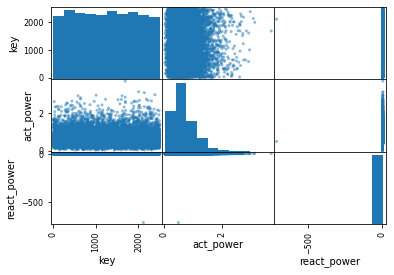

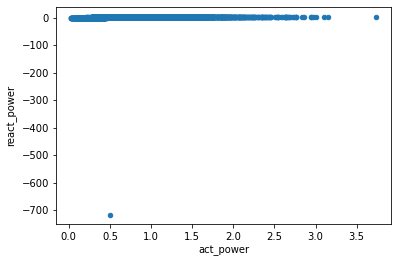

In [21]:
# сначала проанализируем data_arc
pd.plotting.scatter_matrix(data_arc)

data_arc.plot(x='act_power', y='react_power', kind='scatter')

In [22]:
# объединим данные по электродам и температуре
# сначала сделаем время в этих таблицах ключами
data_temp_time_idx = data_temp.set_index('time') # в этом датасете будем хранить данные по температуре с индексами по времени
data_temp_time_idx.info()
display(data_temp_time_idx.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11577 entries, 2019-05-03 11:16:18 to 2019-08-06 03:00:28
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     11577 non-null  int64  
 1   temp    11577 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 271.3 KB


,key,temp
time,,
2019-05-03 11:16:18,1,1571.0
2019-05-03 11:25:53,1,1604.0
2019-05-03 11:29:11,1,1618.0
2019-05-03 11:30:01,1,1601.0
2019-05-03 11:30:39,1,1613.0


In [23]:
data_arc_temp = data_arc.copy() # в этом датасете будем хранить данные по электродам и температуре с индексами по времени
data_arc_temp['duration'] = data_arc_temp['end_time'] - data_arc_temp['begin_time']
data_arc_temp.drop(['end_time'], axis=1, inplace=True)
data_arc_temp.rename(columns = {'begin_time' : 'time'}, inplace = True)
data_arc_temp.set_index('time', inplace=True) 
data_arc_temp.info()
display(data_arc_temp.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10919 entries, 2019-05-03 11:02:14 to 2019-08-06 02:54:31
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   key          10919 non-null  int64          
 1   act_power    10919 non-null  float64        
 2   react_power  10919 non-null  float64        
 3   duration     10919 non-null  timedelta64[ns]
dtypes: float64(2), int64(1), timedelta64[ns](1)
memory usage: 426.5 KB


,key,act_power,react_power,duration
time,,,,
2019-05-03 11:02:14,1,0.976059,0.687084,0 days 00:03:48
2019-05-03 11:07:28,1,0.805607,0.520285,0 days 00:03:05
2019-05-03 11:11:44,1,0.744363,0.498805,0 days 00:02:52
2019-05-03 11:18:14,1,1.659363,1.062669,0 days 00:06:05
2019-05-03 11:26:09,1,0.692755,0.414397,0 days 00:02:28


In [24]:
data_arc_temp = pd.merge(data_arc_temp, data_temp_time_idx, how ='outer', left_index=True, right_index=True)
data_arc_temp['key_x'] = np.where(data_arc_temp['key_x'].isna(), data_arc_temp['key_y'], data_arc_temp['key_x'])
data_arc_temp['key_x'] = data_arc_temp['key_x'].astype(np.int)
data_arc_temp.drop(['key_y'], axis=1, inplace=True)
data_arc_temp.rename(columns = {'key_x' : 'key'}, inplace = True)
data_arc_temp.info()
display(data_arc_temp.head(40))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22496 entries, 2019-05-03 11:02:14 to 2019-08-06 03:00:28
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   key          22496 non-null  int32          
 1   act_power    10919 non-null  float64        
 2   react_power  10919 non-null  float64        
 3   duration     10919 non-null  timedelta64[ns]
 4   temp         11577 non-null  float64        
dtypes: float64(3), int32(1), timedelta64[ns](1)
memory usage: 966.6 KB


,key,act_power,react_power,duration,temp
time,,,,,
2019-05-03 11:02:14,1,0.976059,0.687084,0 days 00:03:48,NaN
2019-05-03 11:07:28,1,0.805607,0.520285,0 days 00:03:05,NaN
2019-05-03 11:11:44,1,0.744363,0.498805,0 days 00:02:52,NaN
2019-05-03 11:16:18,1,NaN,NaN,NaT,1571.0
2019-05-03 11:18:14,1,1.659363,1.062669,0 days 00:06:05,NaN
2019-05-03 11:25:53,1,NaN,NaN,NaT,1604.0
2019-05-03 11:26:09,1,0.692755,0.414397,0 days 00:02:28,NaN
2019-05-03 11:29:11,1,NaN,NaN,NaT,1618.0
2019-05-03 11:30:01,1,NaN,NaN,NaT,1601.0


In [25]:
null_delta = datetime.timedelta(days=0,
                                seconds=0, 
                                microseconds=0, 
                                milliseconds=0, 
                                minutes=0, 
                                hours=0, 
                                weeks=0)

In [26]:
data_arc_temp['duration'].fillna(null_delta, inplace=True) # заполняем пропуски в длительности чтобы потом можно было перевести ее в целые числа и провести корелляционный анализ
data_arc_temp['duration'] = data_arc_temp['duration'].astype('timedelta64[s]') # переводим время в секунды
data_arc_temp['duration'] = data_arc_temp['duration'].astype(np.int64)

In [27]:
# интерполируем данные по температуре (понимаем, что это очень грубо)
data_arc_temp['temp'] = data_arc_temp['temp'].interpolate()

In [28]:
# удаляем все пропуски
data_arc_temp.dropna(inplace=True)
display(data_arc_temp.head(10))

,key,act_power,react_power,duration,temp
time,,,,,
2019-05-03 11:18:14,1,1.659363,1.062669,365,1587.5
2019-05-03 11:26:09,1,0.692755,0.414397,148,1611.0
2019-05-03 11:34:14,2,0.438063,0.283043,137,1597.0
2019-05-03 11:38:50,2,1.296415,0.892914,338,1581.0
2019-05-03 11:46:19,2,0.490377,0.305281,126,1585.0
2019-05-03 11:49:48,2,0.827743,0.516874,210,1596.5
2019-05-03 12:06:54,3,1.062053,0.671494,280,1599.0
2019-05-03 12:13:52,3,0.484206,0.312100,124,1596.5
2019-05-03 12:18:56,3,0.429355,0.271774,109,1597.5


In [29]:
data_arc_temp.drop('key', axis=1).corr()

,act_power,react_power,duration,temp
act_power,1.000000,0.047241,0.972811,-0.258433
react_power,0.047241,1.000000,0.049518,-0.003983
duration,0.972811,0.049518,1.000000,-0.234766
temp,-0.258433,-0.003983,-0.234766,1.000000


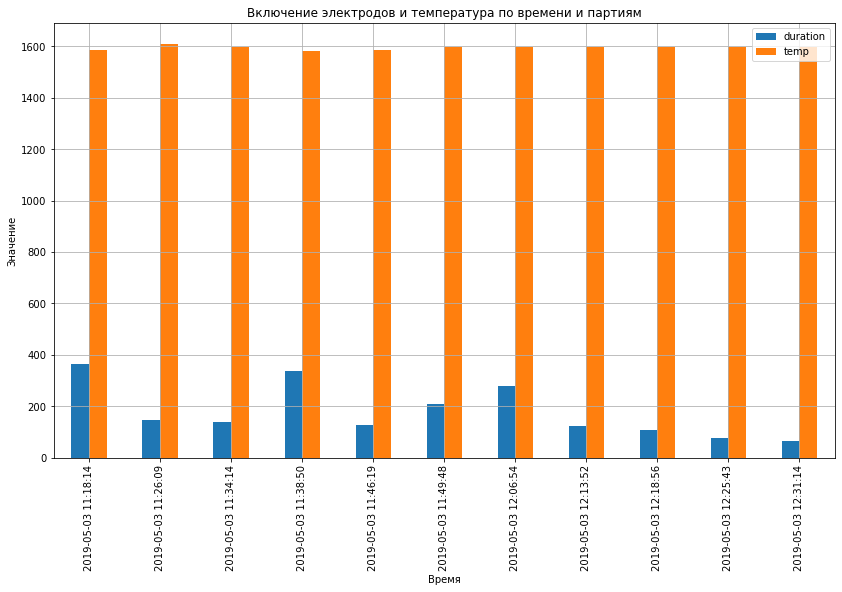

In [31]:
data_arc_temp.query('key < 4').drop(['key', 'act_power', 'react_power'], axis=1).plot(grid=True, kind='bar', figsize=(14, 8))
plt.title('Включение электродов и температура по времени и партиям')
plt.ylabel('Значение')
plt.xlabel('Время')
plt.show()

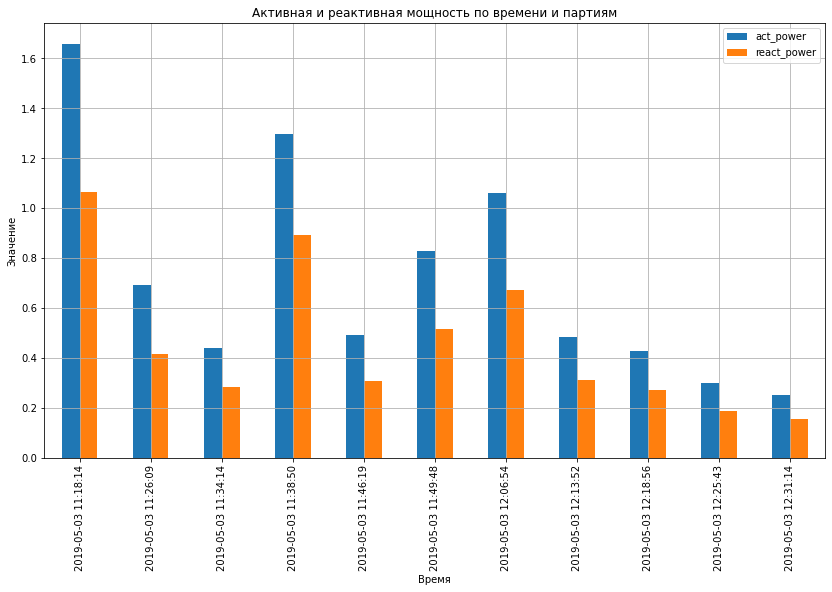

In [32]:
data_arc_temp.query('key < 4').drop(['key', 'temp', 'duration'], axis=1).plot(grid=True, kind='bar', figsize=(14, 8))
plt.title('Активная и реактивная мощность по времени и партиям')
plt.ylabel('Значение')
plt.xlabel('Время')
plt.show()

### 2.3.2. Выводы (электроды и температура):
1. Включение электродов и замеры температуры идут с разной периодичностью в каждой партии.
2. Как ни странно, но корелляции между активной и реактивной мощностью практически не наблюдается (хотя по логике между ними должна быть линейная зависимость).
3. Есть сильная зависимость между длительностью включения электродов и активной потребялемой мощностью.
4. Зависимость температуры от времени включения электродов, мощности не обнаружена.

### 2.3.3. Данные по температуре

In [34]:
# посмотрим на температуру
# нас интересуют (как целевой признак) именно последние замеры температуры в каждой партии
data_temp_last = data_temp.pivot_table(index='key', columns=None, values='time', aggfunc='max') # в этом датасете будем хранить целевые признаки
display(data_temp_last.head())

,time
key,
1,2019-05-03 11:30:39
2,2019-05-03 11:59:12
3,2019-05-03 12:34:57
4,2019-05-03 12:59:25
5,2019-05-03 13:36:01


In [35]:
time_index = data_temp_last['time']
data_temp_last = data_temp.query('time in @time_index').reset_index(drop=True)
display(data_temp_last.head())
data_temp_last.info()

,key,time,temp
0,1,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:36:01,1602.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     2325 non-null   int64         
 1   time    2325 non-null   datetime64[ns]
 2   temp    2325 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 54.6 KB


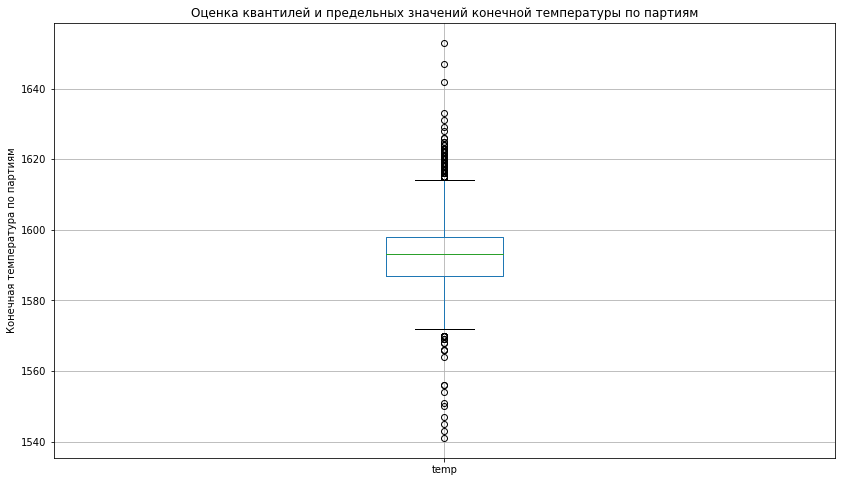

In [36]:
data_temp_last.boxplot(column='temp', figsize=(14, 8))
plt.title('Оценка квантилей и предельных значений конечной температуры по партиям')
plt.ylabel('Конечная температура по партиям')
plt.show()

In [37]:
q3_final_temp, q1_final_temp, mn_final_temp, mx_final_temp = calc_quantiles(data_temp_last['temp'])
print(f'В основном значения конечной температуры лежат между квантилями в промежутке от {q1_final_temp} до {q3_final_temp}. Значения выше {mx_final_temp} и ниже {mn_final_temp} можно расценивать как выбросы.')
display(data_temp_last['temp'].describe())
#print_param(data_temp_last['temp'])

В основном значения конечной температуры лежат между квантилями в промежутке от 1587.0 до 1598.0. Значения выше 1614.5 и ниже 1570.5 можно расценивать как выбросы.


count    2325.000000
mean     1593.366022
std        11.209581
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1598.000000
max      1653.000000
Name: temp, dtype: float64

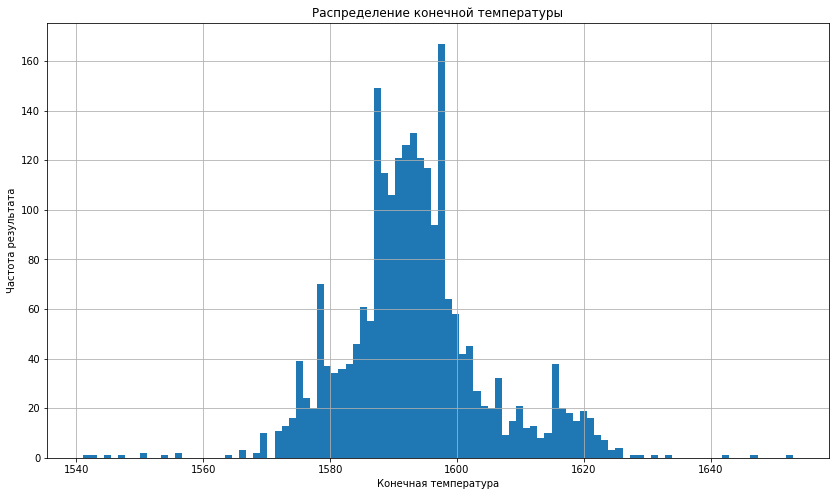

In [39]:
data_temp_last['temp'].hist(bins=100, figsize=(14, 8))
plt.title('Распределение конечной температуры')
plt.ylabel('Частота результата')
plt.xlabel('Конечная температура')
plt.show()

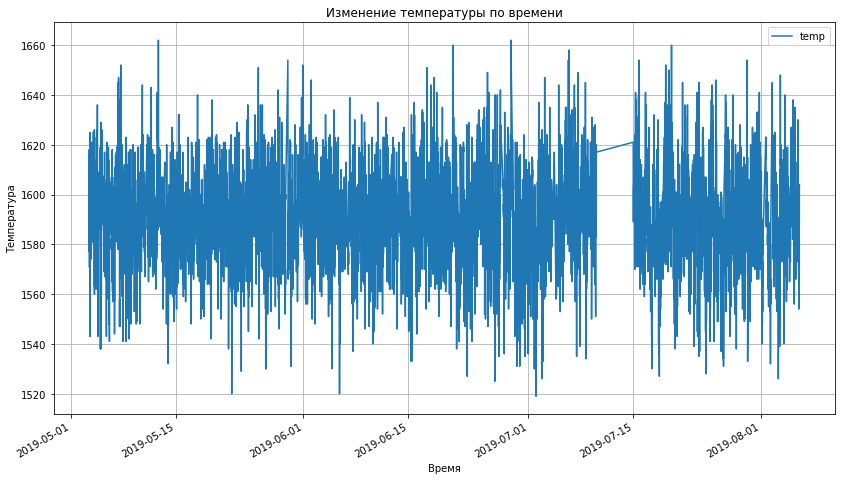

In [40]:
data_temp.set_index('time').drop(['key'], axis=1).plot(grid=True, kind='line', figsize=(14, 8))
plt.title('Изменение температуры по времени')
plt.ylabel('Температура')
plt.xlabel('Время')
plt.show()

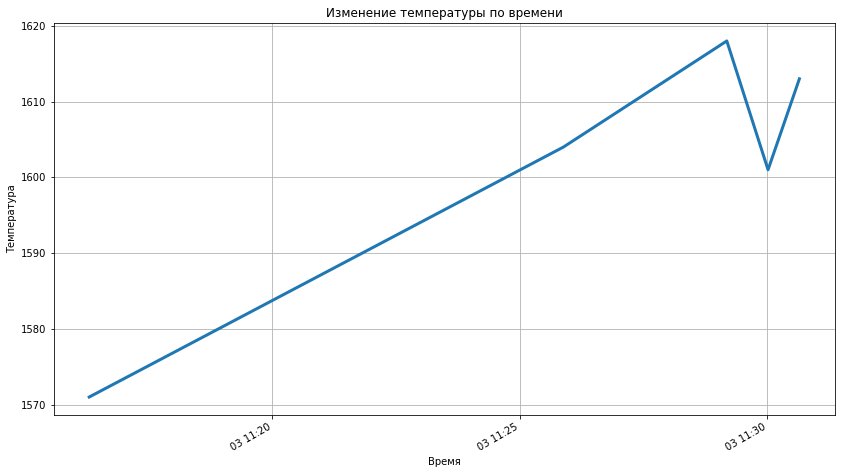

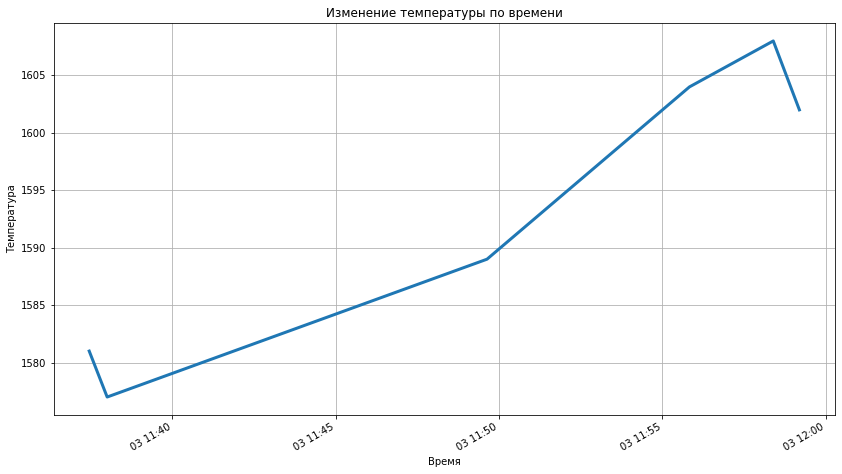

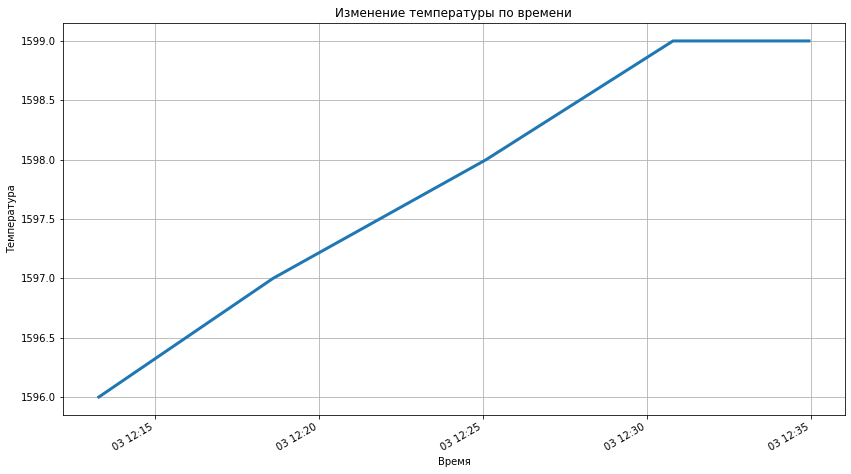

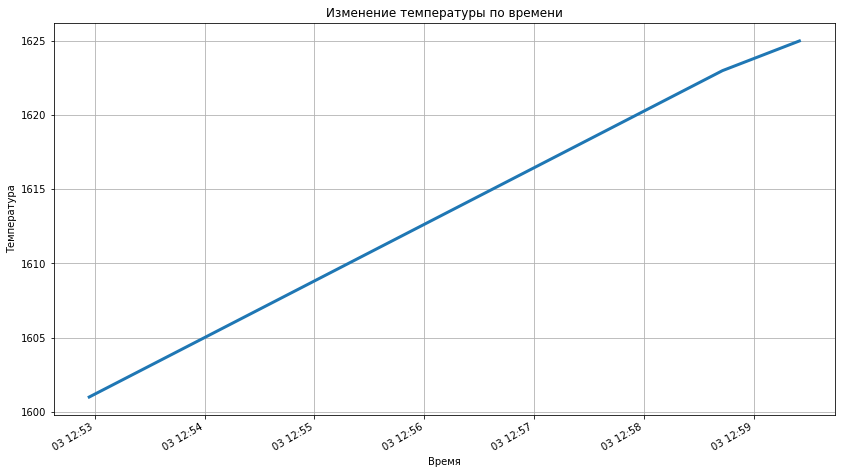

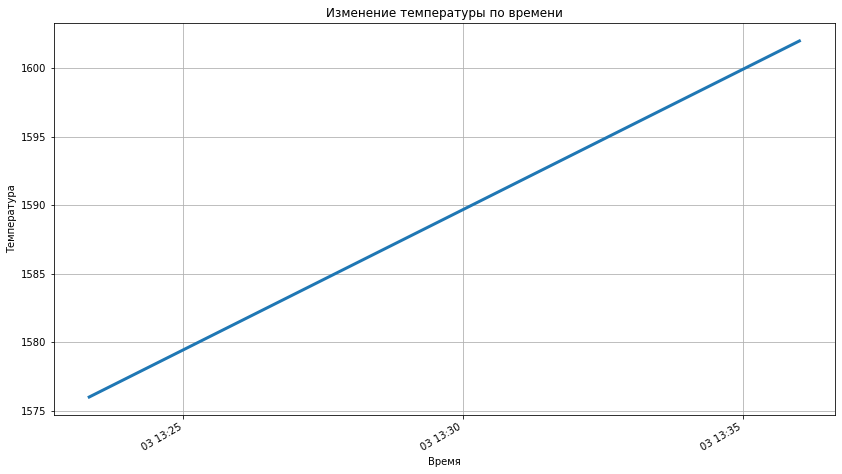

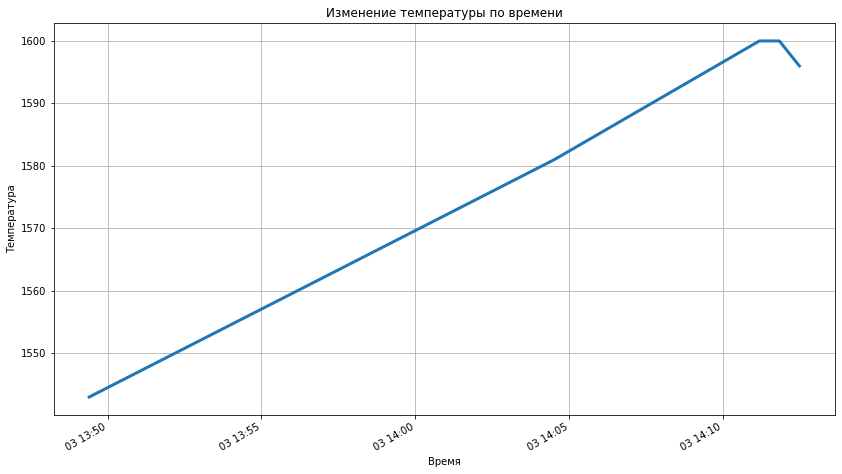

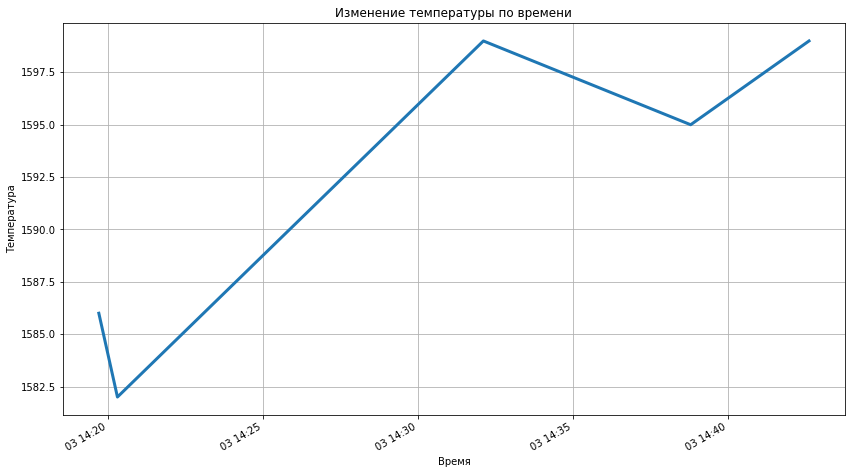

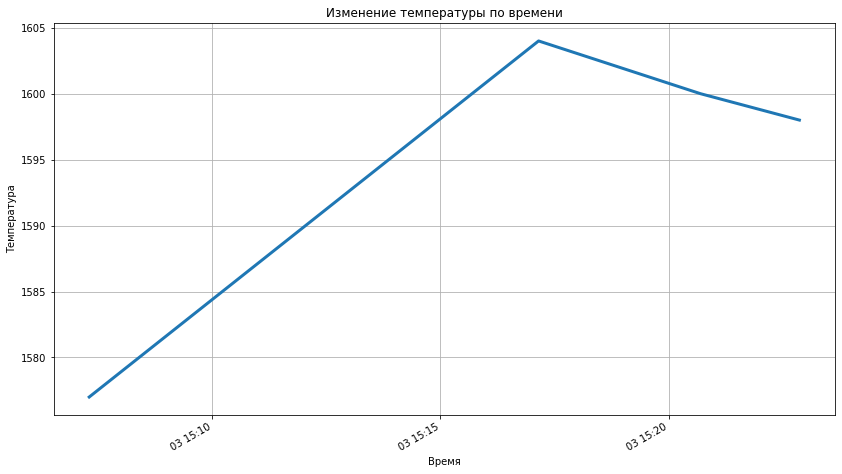

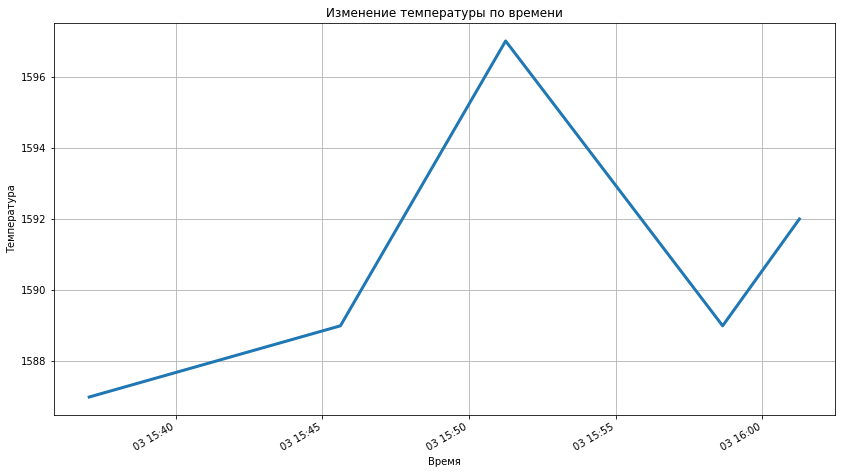

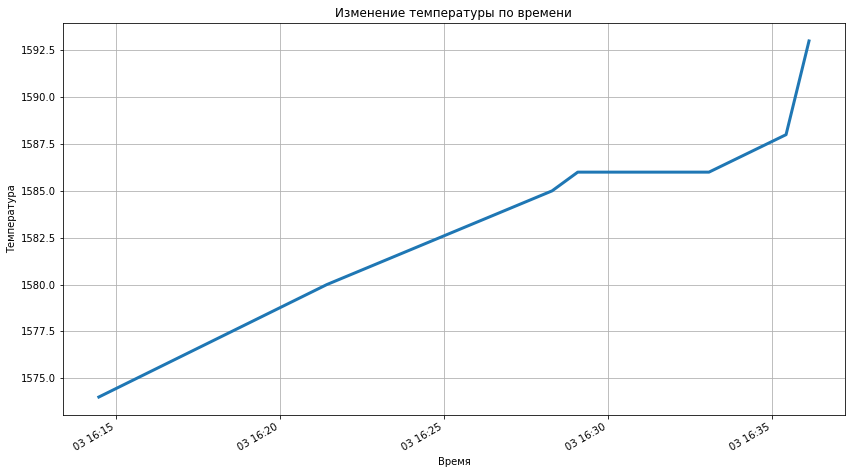

In [41]:
for i in range(10):
    n = i + 1
    data_temp.query('key==@n').set_index('time').drop(['key'], axis=1).plot(grid=True, kind='line', legend=False, linewidth=3, figsize=(14, 8))
    plt.title('Изменение температуры по времени')
    plt.ylabel('Температура')
    plt.xlabel('Время')
    plt.show()

### 2.3.4. Выводы (температура):
1. Распределение конечной температуры близко к нормальному с небольшим смещением.
2. Есть несколько сильных выбросов и довольно много слабых. Но мы их не удаляем - работаем как есть.
3. Замеры температур по партиям производятся с разной периодичностью, на наблюдаемом периоде температура обычно возрастает, но бывают и случаи ее снижения. Но мы не обращаем на это внимания по условия задачи.
4. Видна большая пауза в процессах в июле.

### 2.3.5. Данные по газу

In [42]:
# посмотрим на газ
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2496
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     2325 non-null   int64  
 1   gas_1   2325 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 54.5 KB


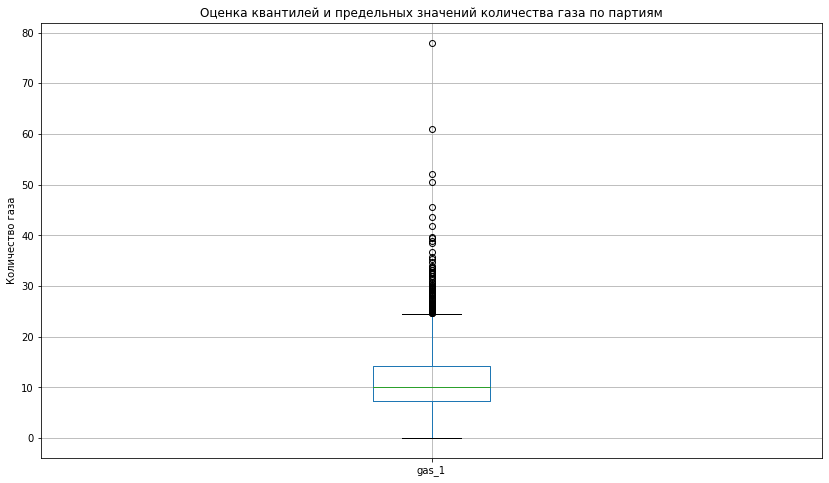

In [43]:
data_gas.boxplot(column='gas_1', figsize=(14, 8))
plt.title('Оценка квантилей и предельных значений количества газа по партиям')
plt.ylabel('Количество газа')
plt.show()

In [44]:
q3_gas, q1_gas, mn_gas, mx_gas = calc_quantiles(data_gas['gas_1'])
print(f'В основном значения количества газа лежат между квантилями в промежутке от {q1_gas} до {q3_gas}. Значения выше {mx_gas} и ниже {mn_gas} можно расценивать как выбросы.')
display(data_gas['gas_1'].describe())
#print_param(data_gas['gas_1'])

В основном значения количества газа лежат между квантилями в промежутке от 7.282947876 до 14.2176909218. Значения выше 24.6198054905 и ниже 0.0083985291 можно расценивать как выбросы.


count    2325.000000
mean       11.378942
std         6.395632
min         0.008399
25%         7.282948
50%        10.100950
75%        14.217691
max        77.995040
Name: gas_1, dtype: float64

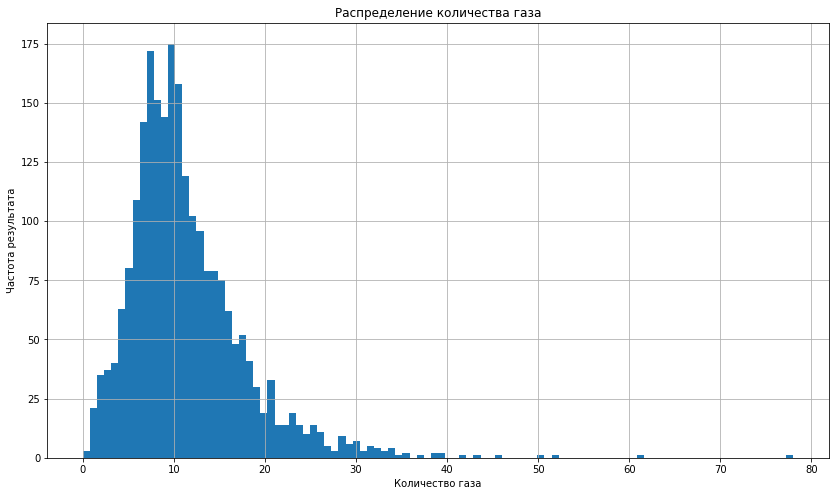

In [46]:
data_gas['gas_1'].hist(bins=100, figsize=(14, 8))
plt.title('Распределение количества газа')
plt.ylabel('Частота результата')
plt.xlabel('Количество газа')
plt.show()

### 2.3.6. Выводы (газ):
1. Распределение конечной температуры близко к нормальному с небольшим смещением.
2. Есть несколько сильных выбросов и довольно много слабых. Но мы их не удаляем - работаем как есть.

### 2.3.7. Данные по сыпучим и проволочным материалам

In [47]:
# объединим данные по подаче сыпучих и проволочных материалов
data_bulk_wire = pd.merge(data_bulk, data_wire, how ='outer', left_index=True, right_index=True)

In [48]:
data_bulk_wire.info()
display(data_bulk_wire.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4650 entries, 2019-05-03 11:11:41 to 2019-08-06 02:40:36
Data columns (total 26 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key_x    2325 non-null   float64
 1   bulk_1   2325 non-null   float64
 2   bulk_2   2325 non-null   float64
 3   bulk_3   2325 non-null   float64
 4   bulk_4   2325 non-null   float64
 5   bulk_5   2325 non-null   float64
 6   bulk_6   2325 non-null   float64
 7   bulk_7   2325 non-null   float64
 8   bulk_8   2325 non-null   float64
 9   bulk_9   2325 non-null   float64
 10  bulk_10  2325 non-null   float64
 11  bulk_11  2325 non-null   float64
 12  bulk_12  2325 non-null   float64
 13  bulk_13  2325 non-null   float64
 14  bulk_14  2325 non-null   float64
 15  bulk_15  2325 non-null   float64
 16  key_y    2325 non-null   float64
 17  wire_1   2325 non-null   float64
 18  wire_2   2325 non-null   float64
 19  wire_3   2325 non-null   float64
 20  wire_4   2325 no

,key_x,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,...,key_y,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
time,,,,,,,,,,,,,,,,,,,,,
2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-05-03 11:21:30,1.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-05-03 11:46:38,2.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,91.160157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


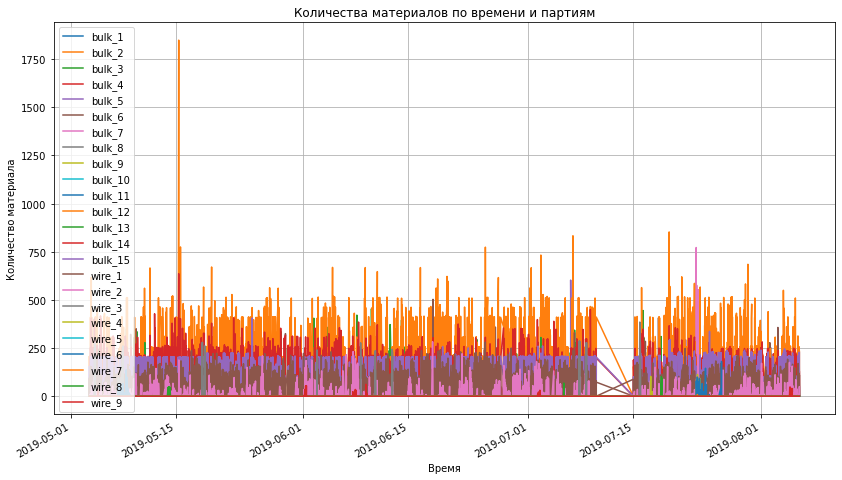

In [49]:
data_bulk_wire.fillna(0, inplace=True)
data_bulk_wire.drop(['key_x','key_y'], axis=1).plot(grid=True, kind='line', figsize=(14, 8))
plt.title('Количества материалов по времени и партиям')
plt.ylabel('Количество материала')
plt.xlabel('Время')
plt.show()

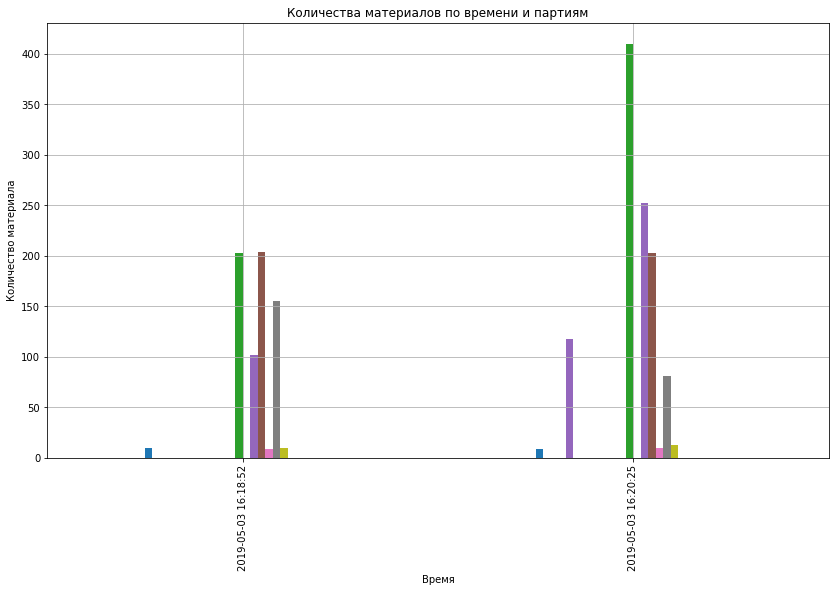

In [50]:
ax = data_bulk_wire.query('key_x==1 or key_y==1').plot(grid=True, kind='bar', figsize=(14, 8), legend=False)
for i in range(9):
    n = i + 2;
    data_bulk_wire.query('key_x==@n or key_y==@n').plot(grid=True, kind='bar', figsize=(14, 8), legend=False, ax=ax) 
    
plt.title('Количества материалов по времени и партиям')
#plt.legend(['По городу', 'В центре'])
plt.ylabel('Количество материала')
plt.xlabel('Время')
plt.show()

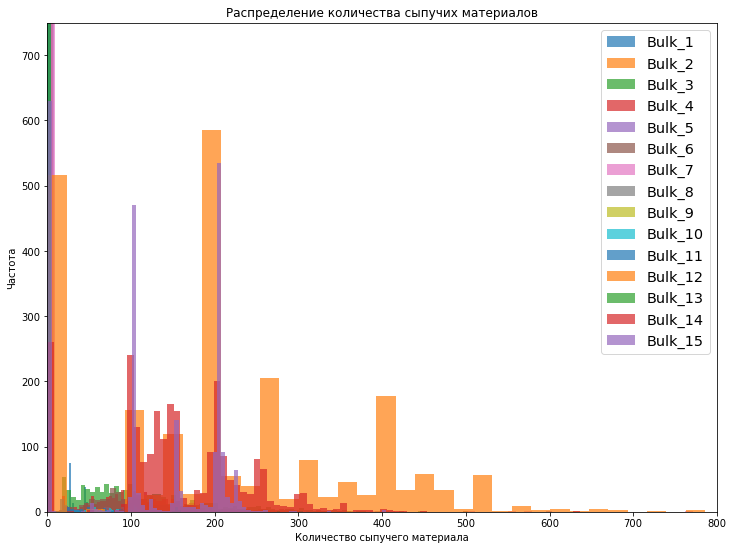

In [51]:
plt.figure(figsize=[12,9])
plt.xlim([0, 800])
plt.ylim([0, 750])

for i in range(15):
    k = f'bulk_{i+1}'
    plt.hist(data_bulk[k], bins=80, label = f'Bulk_{i+1}', alpha=0.7)

plt.xlabel('Количество сыпучего материала')
plt.ylabel('Частота')
plt.legend(loc='upper right', fontsize='x-large')
plt.title('Распределение количества сыпучих материалов')
plt.show()

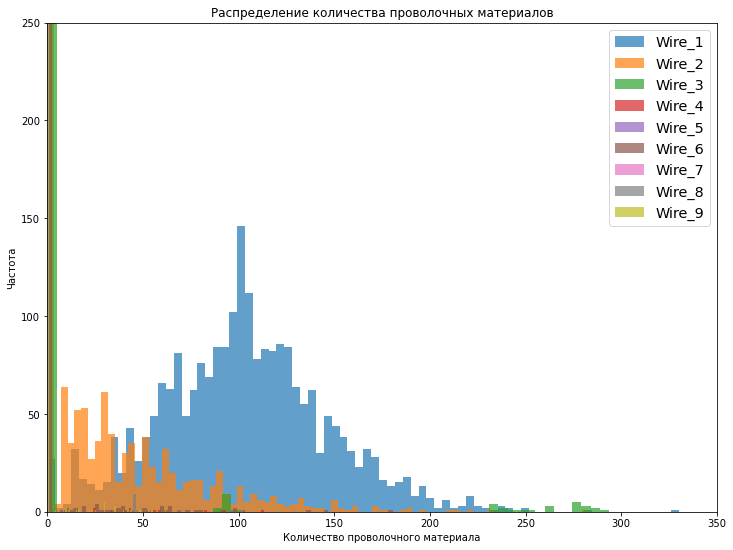

In [52]:
plt.figure(figsize=[12,9])
plt.xlim([0, 350])
plt.ylim([0, 250])

for i in range(9):
    k = f'wire_{i+1}'
    plt.hist(data_wire[k], bins=80, label = f'Wire_{i+1}', alpha=0.7)

plt.xlabel('Количество проволочного материала')
plt.ylabel('Частота')
plt.legend(loc='upper right', fontsize='x-large')
plt.title('Распределение количества проволочных материалов')
plt.show()

### 2.3.8. Выводы (по сыпучим и проволочным материалам):
1. Сыпучие и проволочные материалы в каждую партию добавляли в разное время. Сначала проволочные, потом - сыпучие.
2. Совмещать эти данные по времени бессмысленно - надо совмещать по ключу партии.
3. Сыпучие вещества добавляются в различных количествах, отличающихся на порядки.

## 3. Задание (дополнительное?)
Вам поручили изучить характеристики процесса обработки стали. Для каждого значения столбца key найдите:
* Длительность времени между первым и последним замером температуры.
* Суммарное время нагрева электродами, то есть сумму значений по всем промежуткам между запусками нагрева электродов.
* Количество запусков нагрева электродами.
* Среднее соотношение потребления активной и реактивной мощности.
<br><br>
<div>По всем полученным столбцам вычислите статистики: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей.</div>

### 3.1. Длительность времени между первым и последним замером температуры

,delta_time
key,
1,861
2,1305
3,1300
4,388
5,762
...,...
2495,1137
2496,1618
2497,717


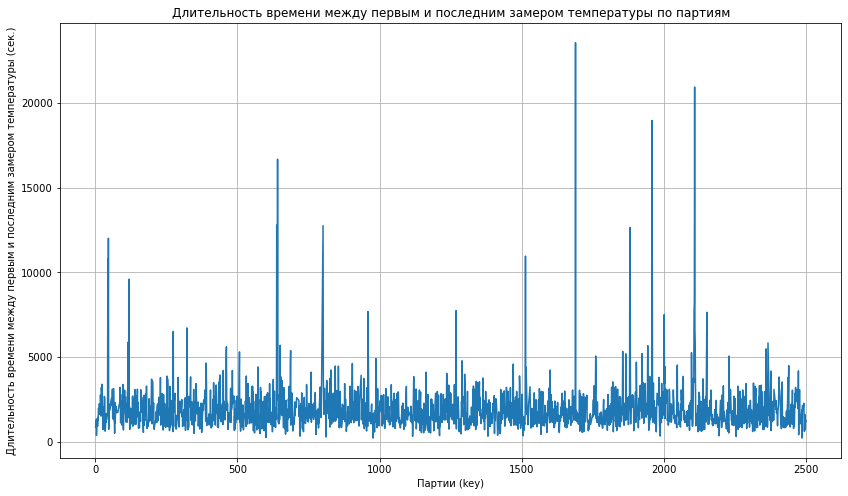

In [53]:
# Для каждого значения столбца key найдите длительность времени между первым и последним замером температуры
delta_time_temp = data_temp.pivot_table(index='key', columns=None, values='time', aggfunc=['min', 'max'])
delta_time_temp.set_axis(['min_time','max_time'],axis = 'columns',inplace = True)
delta_time_temp['delta_time'] = delta_time_temp['max_time'] - delta_time_temp['min_time']
delta_time_temp = delta_time_temp.drop(['min_time','max_time'], axis=1)
delta_time_temp['delta_time'] = delta_time_temp['delta_time'].astype('timedelta64[s]').astype(np.int32) # переводим время в секунды
display(delta_time_temp)
delta_time_temp.plot(grid=True, figsize=(14, 8), legend=None)
plt.title('Длительность времени между первым и последним замером температуры по партиям')
plt.ylabel('Длительность времени между первым и последним замером температуры (сек.)')
plt.xlabel('Партии (key)')
plt.show()

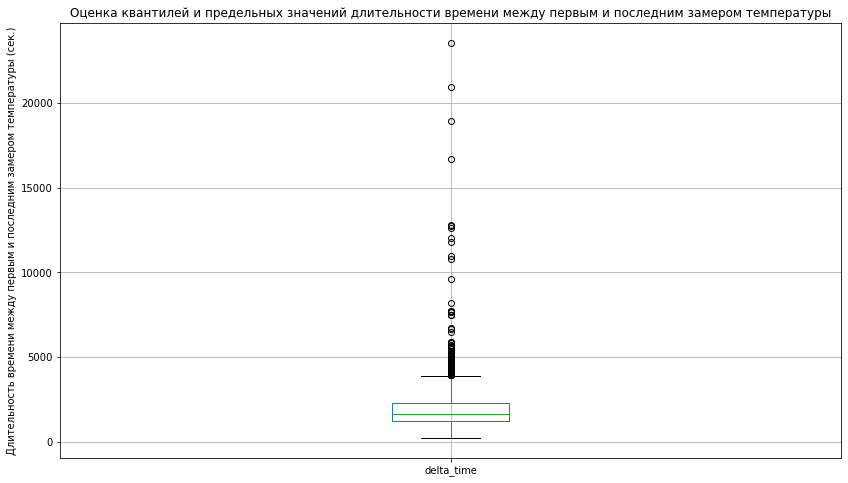

In [54]:
delta_time_temp.boxplot(column='delta_time', figsize=(14, 8))
plt.title('Оценка квантилей и предельных значений длительности времени между первым и последним замером температуры')
plt.ylabel('Длительность времени между первым и последним замером температуры (сек.)')
plt.show()

In [55]:
q3_temp, q1_temp, mn_temp, mx_temp = calc_quantiles(delta_time_temp['delta_time'])
print(f'В основном значения длительности времени между первым и последним замером температуры лежат между квантилями в промежутке от {q1_temp} сек. до {q3_temp} сек. Значения выше {mx_temp} сек. и ниже {mn_temp} сек. можно расценивать как выбросы.')
display(delta_time_temp['delta_time'].describe())
#print_param(delta_time_temp['delta_time'])

В основном значения длительности времени между первым и последним замером температуры лежат между квантилями в промежутке от 1215.0 сек. до 2292.0 сек. Значения выше 3907.5 сек. и ниже 234 сек. можно расценивать как выбросы.


count     2325.000000
mean      1898.912688
std       1323.040979
min        234.000000
25%       1215.000000
50%       1634.000000
75%       2292.000000
max      23537.000000
Name: delta_time, dtype: float64

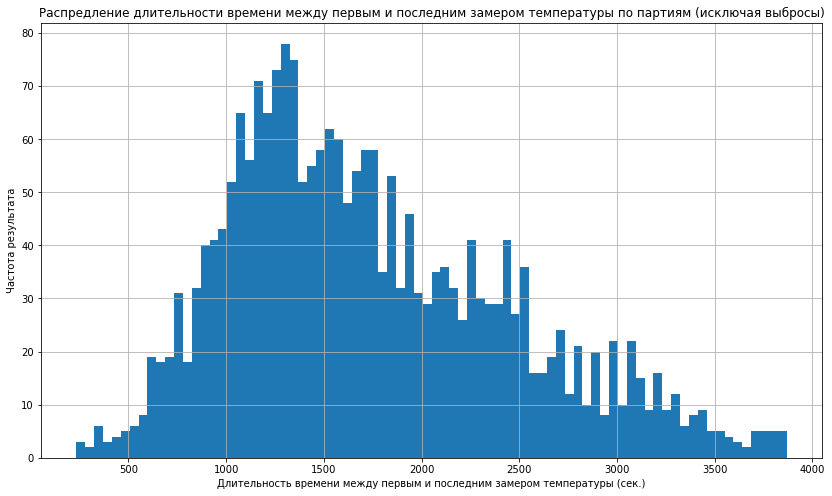

In [56]:
delta_time_temp.query('delta_time <= 3868').hist(bins=80, figsize=(14, 8))
plt.title('Распредление длительности времени между первым и последним замером температуры по партиям (исключая выбросы)')
plt.ylabel('Частота результата')
plt.xlabel('Длительность времени между первым и последним замером температуры (сек.)')
plt.show()

## 3.2. Суммарное время нагрева электродами

,delta_time
key,
1,1098
2,811
3,655
4,741
5,869
...,...
2495,723
2496,940
2497,569


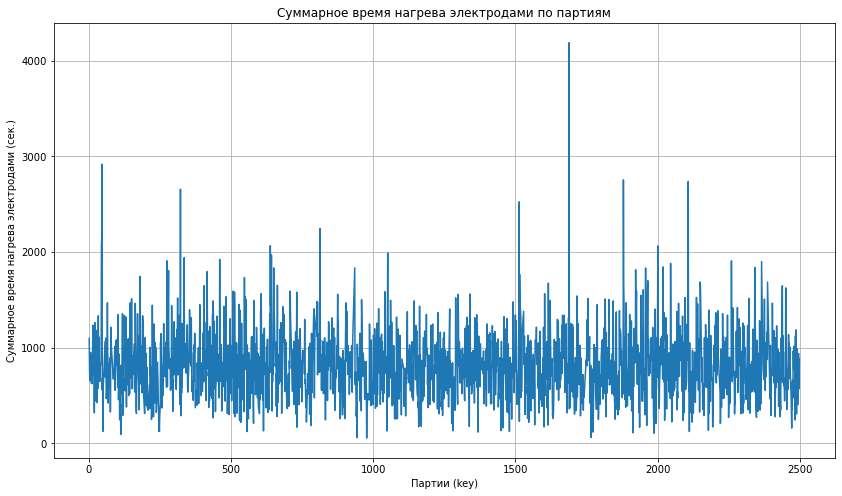

In [58]:
# Для каждого значения столбца key найдите cуммарное время нагрева электродами, то есть сумму значений по всем промежуткам между запусками нагрева электродов
data_arc['delta_time'] = data_arc['end_time'] - data_arc['begin_time']
delta_time_arc = data_arc.pivot_table(index='key', values='delta_time', aggfunc=np.sum)
delta_time_arc.set_axis(['delta_time'],axis = 'columns',inplace = True)
delta_time_arc['delta_time'] = delta_time_arc['delta_time'].astype('timedelta64[s]').astype(np.int32) # переводим время в секунды
display(delta_time_arc)
delta_time_arc.plot(grid=True, figsize=(14, 8), legend=None)
plt.title('Cуммарное время нагрева электродами по партиям')
plt.ylabel('Суммарное время нагрева электродами (сек.)')
plt.xlabel('Партии (key)')
plt.show()

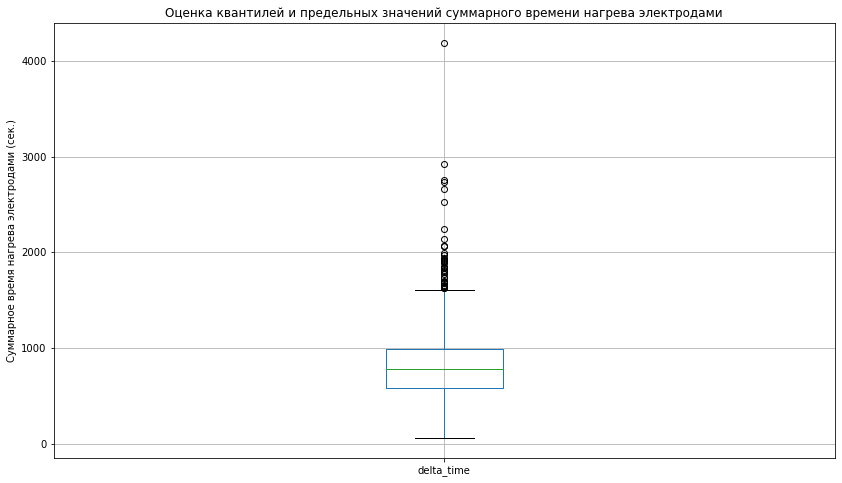

In [59]:
delta_time_arc.boxplot(column='delta_time', figsize=(14, 8))
plt.title('Оценка квантилей и предельных значений суммарного времени нагрева электродами')
plt.ylabel('Суммарное время нагрева электродами (сек.)')
plt.show()

In [60]:
q3_arc, q1_arc, mn_arc, mx_arc = calc_quantiles(delta_time_arc['delta_time'])
print(f'В основном значения cуммарного времени нагрева электродами лежат между квантилями в промежутке от {q1_arc} сек. до {q3_arc} сек. Значения выше {mx_arc} сек. и ниже {mn_arc} сек. можно расценивать как выбросы.')
display(delta_time_arc['delta_time'].describe())
#print_param(delta_time_arc['delta_time'])

В основном значения cуммарного времени нагрева электродами лежат между квантилями в промежутке от 581.0 сек. до 993.0 сек. Значения выше 1611.0 сек. и ниже 57 сек. можно расценивать как выбросы.


count    2325.000000
mean      808.035269
std       340.829330
min        57.000000
25%       581.000000
50%       778.000000
75%       993.000000
max      4189.000000
Name: delta_time, dtype: float64

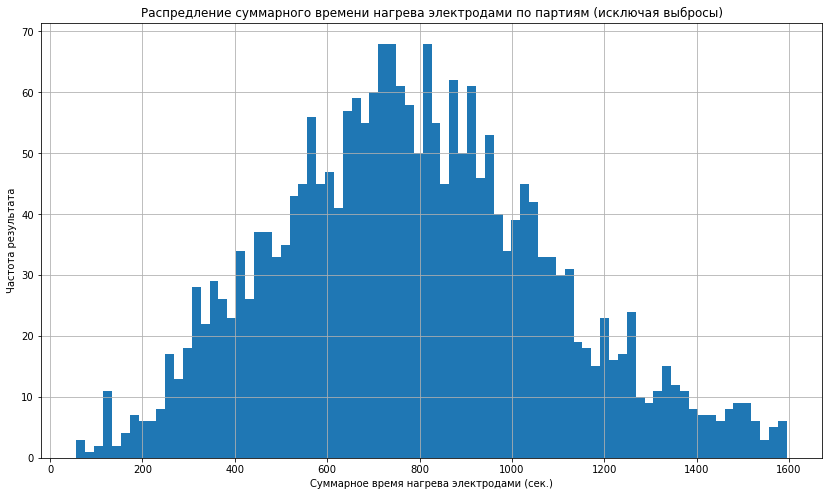

In [61]:
delta_time_arc.query('delta_time <= 1603').hist(bins=80, figsize=(14, 8))
plt.title('Распредление суммарного времени нагрева электродами по партиям (исключая выбросы)')
plt.ylabel('Частота результата')
plt.xlabel('Суммарное время нагрева электродами (сек.)')
plt.show()

## 3.3. Количество запусков нагрева электродами

,start
key,
1,5
2,4
3,5
4,4
5,4
...,...
2495,4
2496,6
2497,3


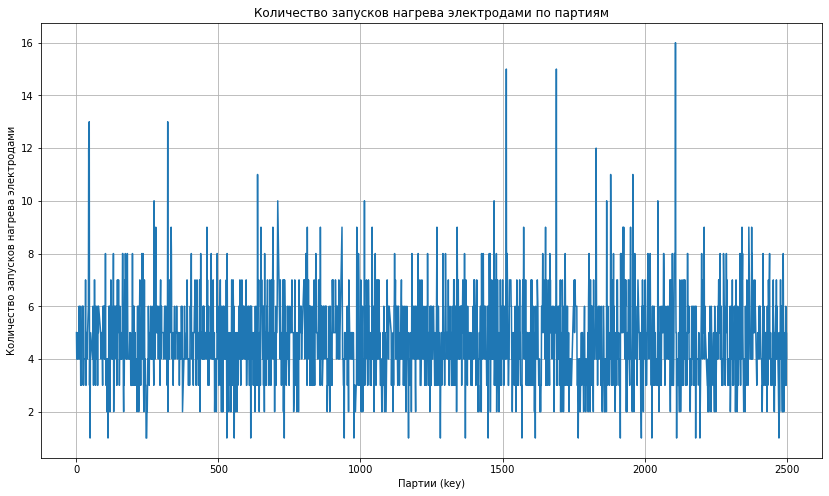

In [63]:
# Количество запусков нагрева электродами
start_arc = data_arc.pivot_table(index='key', values='begin_time', aggfunc='count')
start_arc.set_axis(['start'],axis = 'columns',inplace = True)
display(start_arc)
start_arc.plot(grid=True, figsize=(14, 8), legend=None)
plt.title('Количество запусков нагрева электродами по партиям')
plt.ylabel('Количество запусков нагрева электродами')
plt.xlabel('Партии (key)')
plt.show()

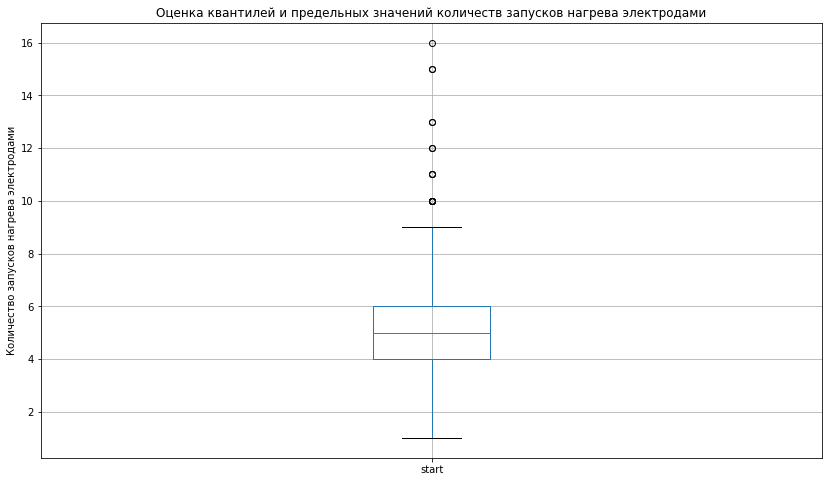

In [64]:
start_arc.boxplot(column='start', figsize=(14, 8))
plt.title('Оценка квантилей и предельных значений количеств запусков нагрева электродами')
plt.ylabel('Количество запусков нагрева электродами')
plt.show()

In [65]:
q3_arc_start, q1_arc_start, mn_arc_start, mx_arc_start = calc_quantiles(start_arc['start'])
print(f'В основном значения количеств запусков нагрева электродами лежат между квантилями в промежутке от {q1_arc_start} до {q3_arc_start}. Значения выше {mx_arc_start} и ниже {mn_arc_start} можно расценивать как выбросы.')
display(start_arc['start'])

В основном значения количеств запусков нагрева электродами лежат между квантилями в промежутке от 4.0 до 6.0. Значения выше 9.0 и ниже 1.0 можно расценивать как выбросы.


key
1       5
2       4
3       5
4       4
5       4
       ..
2495    4
2496    6
2497    3
2498    5
2499    4
Name: start, Length: 2325, dtype: int64

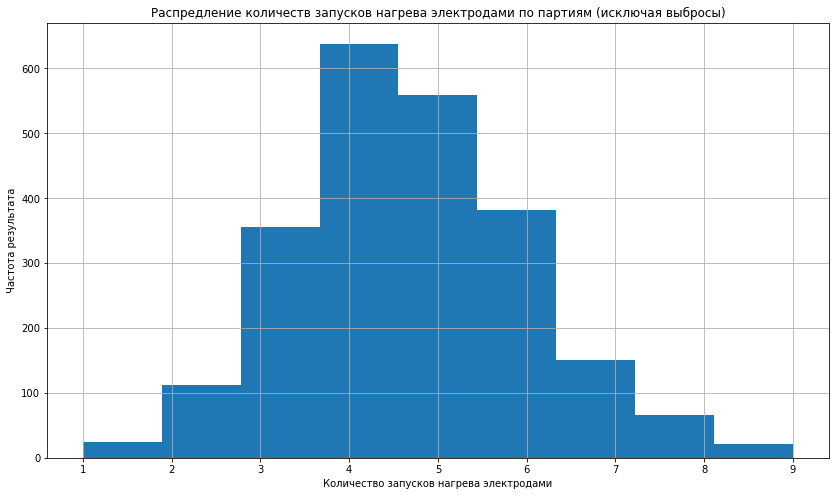

In [66]:
start_arc.query('start <= 9').hist(bins=9, figsize=(14, 8))
plt.title('Распредление количеств запусков нагрева электродами по партиям (исключая выбросы)')
plt.ylabel('Частота результата')
plt.xlabel('Количество запусков нагрева электродами')
plt.show()

## 3.4. Среднее соотношение потребления активной и реактивной мощности

,act_react
key,
1,1.538898
2,1.551834
3,1.583120
4,1.563487
5,1.480428
...,...
2495,1.372734
2496,1.491059
2497,1.192036


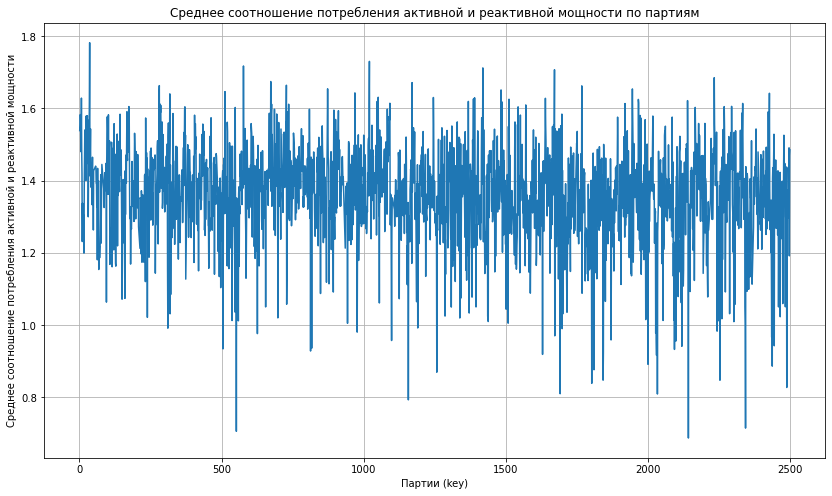

In [68]:
# Среднее соотношение потребления активной и реактивной мощности
data_arc['act_react'] = data_arc['act_power'] / data_arc['react_power']
act_react_arc = data_arc.pivot_table(index='key', values='act_react', aggfunc='mean')
act_react_arc.set_axis(['act_react'],axis = 'columns',inplace = True)

display(act_react_arc)
act_react_arc.plot(grid=True, figsize=(14, 8), legend=None)
plt.title('Среднее соотношение потребления активной и реактивной мощности по партиям')
plt.ylabel('Среднее соотношение потребления активной и реактивной мощности')
plt.xlabel('Партии (key)')
plt.show()

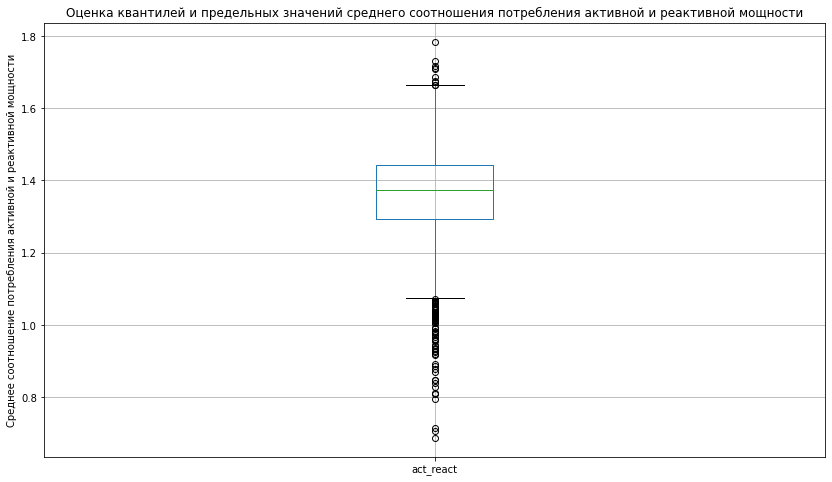

In [69]:
act_react_arc.boxplot(column='act_react', figsize=(14, 8))
plt.title('Оценка квантилей и предельных значений среднего соотношения потребления активной и реактивной мощности')
plt.ylabel('Среднее соотношение потребления активной и реактивной мощности')
plt.show()

In [70]:
act_react_arc['act_react'] = act_react_arc['act_react'] * 1000 # умножаем, чтобы взять точность до тысячных

q3_act_react_arc, q1_act_react_arc, mn_act_react_arc, mx_act_react_arc = calc_quantiles(act_react_arc['act_react'])
q3_act_react_arc = q3_act_react_arc / 1000
q1_act_react_arc = q1_act_react_arc / 1000
mn_act_react_arc = mn_act_react_arc / 1000
mx_act_react_arc = mx_act_react_arc / 1000
print(f'В основном значения среднего соотношения потребления активной и реактивной мощности лежат между квантилями в промежутке от {q1_act_react_arc} до {q3_act_react_arc}. Значения выше {mx_act_react_arc} и ниже {mn_act_react_arc} можно расценивать как выбросы.')

act_react_arc['act_react'] = act_react_arc['act_react'] / 1000 # возвращаем исходные значения

display(act_react_arc['act_react'].describe())

В основном значения среднего соотношения потребления активной и реактивной мощности лежат между квантилями в промежутке от 1.2938876810372852 до 1.4414182398285433. Значения выше 1.6627140780154304 и ниже 1.0725918428503982 можно расценивать как выбросы.


count    2325.000000
mean        1.361221
std         0.131635
min         0.687735
25%         1.293888
50%         1.373416
75%         1.441418
max         1.782164
Name: act_react, dtype: float64

# 4. Подготовка общего датафрейма

## 4.1. В тех датасетах, где для каждой партии есть по несколько записей, необходимо провести агрегацию данных в одну запись
### 4.1.1. Из датасета по электродам мы берем суммарное время работы дуги и средние мощности (активную и реактивную)

In [72]:
display(data_arc.head())
delta_time_arc.reset_index(inplace=True)
display(delta_time_arc.head())

,key,begin_time,end_time,act_power,react_power,delta_time,act_react
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,0 days 00:03:48,1.420582
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0 days 00:03:05,1.548395
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0 days 00:02:52,1.492292
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,0 days 00:06:05,1.561504
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0 days 00:02:28,1.671717


,key,delta_time
0,1,1098
1,2,811
2,3,655
3,4,741
4,5,869


In [73]:
mean_act_power_arc = data_arc.pivot_table(index='key', values='act_power', aggfunc=np.mean).reset_index()
display(mean_act_power_arc.head())

,key,act_power
0,1,0.975629
1,2,0.763150
2,3,0.505176
3,4,0.802313
4,5,0.836793


In [74]:
mean_react_power_arc = data_arc.pivot_table(index='key', values='react_power', aggfunc=np.mean).reset_index()
display(mean_react_power_arc.head())

,key,react_power
0,1,0.636648
1,2,0.499528
2,3,0.319815
3,4,0.515074
4,5,0.563161


In [75]:
sum_data = delta_time_arc.merge(mean_act_power_arc, on='key', how='left')
sum_data = sum_data.merge(mean_react_power_arc, on='key', how='left')
# или вместо 2х верних строк - 2 строки ниже, если берем среднее отношения активной к реактивной мощности из задания выше
#act_react_arc.reset_index(inplace=True)
#sum_data = delta_time_arc.merge(act_react_arc, on='key', how='left')

# для пробы введем и среднее отношения активной к реактивной мощности не удаляя сами мощности 
act_react_arc.reset_index(inplace=True)
sum_data = sum_data.merge(act_react_arc, on='key', how='left')

display(sum_data.head())

,key,delta_time,act_power,react_power,act_react
0,1,1098,0.975629,0.636648,1.538898
1,2,811,0.763150,0.499528,1.551834
2,3,655,0.505176,0.319815,1.583120
3,4,741,0.802313,0.515074,1.563487
4,5,869,0.836793,0.563161,1.480428


In [76]:
# добавляем количество запусков дуги
start_arc.reset_index(inplace=True)
sum_data = sum_data.merge(start_arc, on='key', how='left')
display(sum_data.head())

,key,delta_time,act_power,react_power,act_react,start
0,1,1098,0.975629,0.636648,1.538898,5
1,2,811,0.763150,0.499528,1.551834,4
2,3,655,0.505176,0.319815,1.583120,5
3,4,741,0.802313,0.515074,1.563487,4
4,5,869,0.836793,0.563161,1.480428,4


### 4.1.2. Из датасета по температурам мы берем только конечные температуры

In [77]:
# этот датафрейм уже почти готов, из него надо удалить время
data_temp_last.drop('time', axis=1, inplace=True)
display(data_temp_last.head())

,key,temp
0,1,1613.0
1,2,1602.0
2,3,1599.0
3,4,1625.0
4,5,1602.0


In [78]:
sum_data = sum_data.merge(data_temp_last, on='key', how='left')
display(sum_data.head())

,key,delta_time,act_power,react_power,act_react,start,temp
0,1,1098,0.975629,0.636648,1.538898,5,1613.0
1,2,811,0.763150,0.499528,1.551834,4,1602.0
2,3,655,0.505176,0.319815,1.583120,5,1599.0
3,4,741,0.802313,0.515074,1.563487,4,1625.0
4,5,869,0.836793,0.563161,1.480428,4,1602.0


In [79]:
# и добавим начальные температуры
data_temp_begin = data_temp.pivot_table(index='key', columns=None, values='time', aggfunc='min') # в этом датасете будем хранить целевые признаки
time_index = data_temp_begin['time']
data_temp_begin = data_temp.query('time in @time_index').reset_index(drop=True)
data_temp_begin.set_axis(['key', 'time', 'begin_temp'],axis ='columns', inplace = True)
data_temp_begin.drop('time', axis=1, inplace = True)
sum_data = sum_data.merge(data_temp_begin, on='key', how='left')
display(sum_data.head())

,key,delta_time,act_power,react_power,act_react,start,temp,begin_temp
0,1,1098,0.975629,0.636648,1.538898,5,1613.0,1571.0
1,2,811,0.763150,0.499528,1.551834,4,1602.0,1581.0
2,3,655,0.505176,0.319815,1.583120,5,1599.0,1596.0
3,4,741,0.802313,0.515074,1.563487,4,1625.0,1601.0
4,5,869,0.836793,0.563161,1.480428,4,1602.0,1576.0


In [80]:
# А еще в орядке эксперимента я добавлю длительность времени между первым и последним замером температуры в секундах
sum_data = sum_data.merge(delta_time_temp, on='key', how='left')
display(sum_data.head(10))
display(sum_data.describe())

,key,delta_time_x,act_power,react_power,act_react,start,temp,begin_temp,delta_time_y
0,1,1098,0.975629,0.636648,1.538898,5,1613.0,1571.0,861
1,2,811,0.763150,0.499528,1.551834,4,1602.0,1581.0,1305
2,3,655,0.505176,0.319815,1.583120,5,1599.0,1596.0,1300
3,4,741,0.802313,0.515074,1.563487,4,1625.0,1601.0,388
4,5,869,0.836793,0.563161,1.480428,4,1602.0,1576.0,762
5,6,952,0.988777,0.672294,1.501854,4,1596.0,1543.0,1385
6,7,673,0.636844,0.390324,1.628748,4,1599.0,1586.0,1374
7,8,913,0.940689,0.670174,1.486391,4,1598.0,1577.0,934
8,9,625,0.416390,0.295734,1.421598,5,1592.0,1587.0,1453
9,10,825,0.487270,0.416019,1.231654,6,1593.0,1574.0,1299


,key,delta_time_x,act_power,react_power,act_react,start,temp,begin_temp,delta_time_y
count,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000
mean,1251.512258,808.035269,0.669310,0.422506,1.361221,4.696344,1593.366022,1587.365161,1898.912688
std,715.099053,340.829330,0.196986,3.718267,0.131635,1.605930,11.209581,23.623144,1323.040979
min,1.000000,57.000000,0.186226,-178.647909,0.687735,1.000000,1541.000000,1519.000000,234.000000
25%,629.000000,581.000000,0.526458,0.392566,1.293888,4.000000,1587.000000,1571.000000,1215.000000
50%,1255.000000,778.000000,0.644934,0.487958,1.373416,5.000000,1593.000000,1587.000000,1634.000000
75%,1868.000000,993.000000,0.792080,0.592560,1.441418,6.000000,1598.000000,1603.000000,2292.000000
max,2499.000000,4189.000000,1.421416,1.134983,1.782164,16.000000,1653.000000,1660.000000,23537.000000


## 4.2. Подсоединяем остальные датасеты

In [81]:
# газ
sum_data = sum_data.merge(data_gas, on='key', how='left')
display(sum_data.head())

,key,delta_time_x,act_power,react_power,act_react,start,temp,begin_temp,delta_time_y,gas_1
0,1,1098,0.975629,0.636648,1.538898,5,1613.0,1571.0,861,29.749986
1,2,811,0.763150,0.499528,1.551834,4,1602.0,1581.0,1305,12.555561
2,3,655,0.505176,0.319815,1.583120,5,1599.0,1596.0,1300,28.554793
3,4,741,0.802313,0.515074,1.563487,4,1625.0,1601.0,388,18.841219
4,5,869,0.836793,0.563161,1.480428,4,1602.0,1576.0,762,5.413692


In [82]:
# сыпучие материалы
data_bulk.reset_index(drop=True, inplace=True)
# суммируем все в один столбец - это не дало эффекта - пока закомментил
#data_bulk['sum_bulk'] = data_bulk['bulk_1']
#for i in range(14):
#    k = f'bulk_{i+2}'
#    data_bulk['sum_bulk'] =+ data_bulk[k]
# остальные удаляем    
#data_bulk.drop(['bulk_1','bulk_2','bulk_3','bulk_4','bulk_5','bulk_6','bulk_7','bulk_8','bulk_9','bulk_10','bulk_11','bulk_12','bulk_13','bulk_14','bulk_15'], axis=1, inplace=True)

sum_data = sum_data.merge(data_bulk, on='key', how='left')
display(sum_data.head())

,key,delta_time_x,act_power,react_power,act_react,start,temp,begin_temp,delta_time_y,gas_1,...,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,1098,0.975629,0.636648,1.538898,5,1613.0,1571.0,861,29.749986,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,811,0.763150,0.499528,1.551834,4,1602.0,1581.0,1305,12.555561,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,655,0.505176,0.319815,1.583120,5,1599.0,1596.0,1300,28.554793,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,741,0.802313,0.515074,1.563487,4,1625.0,1601.0,388,18.841219,...,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,869,0.836793,0.563161,1.480428,4,1602.0,1576.0,762,5.413692,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [83]:
# проволочные материалы
data_wire.reset_index(drop=True, inplace=True)
# суммируем все в один столбец - это не дало эффекта - пока закомментил
#data_wire['sum_wire'] = data_wire['wire_1']
#for i in range(8):
#    k = f'wire_{i+2}'
#    data_wire['sum_wire'] =+ data_wire[k]
# остальные удаляем    
#data_wire.drop(['wire_1','wire_2','wire_3','wire_4','wire_5','wire_6','wire_7','wire_8','wire_9'], axis=1, inplace=True)

sum_data = sum_data.merge(data_wire, on='key', how='left')
display(sum_data.head(10))
sum_data.info()
display(sum_data.describe())

,key,delta_time_x,act_power,react_power,act_react,start,temp,begin_temp,delta_time_y,gas_1,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,1098,0.975629,0.636648,1.538898,5,1613.0,1571.0,861,29.749986,...,154.0,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,811,0.763150,0.499528,1.551834,4,1602.0,1581.0,1305,12.555561,...,154.0,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,655,0.505176,0.319815,1.583120,5,1599.0,1596.0,1300,28.554793,...,153.0,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,741,0.802313,0.515074,1.563487,4,1625.0,1601.0,388,18.841219,...,154.0,89.063515,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,869,0.836793,0.563161,1.480428,4,1602.0,1576.0,762,5.413692,...,152.0,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,952,0.988777,0.672294,1.501854,4,1596.0,1543.0,1385,11.273392,...,154.0,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,673,0.636844,0.390324,1.628748,4,1599.0,1586.0,1374,9.836267,...,154.0,98.061600,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,913,0.940689,0.670174,1.486391,4,1598.0,1577.0,934,15.171553,...,153.0,155.282394,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,625,0.416390,0.295734,1.421598,5,1592.0,1587.0,1453,8.216623,...,203.0,113.393279,9.143681,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,825,0.487270,0.416019,1.231654,6,1593.0,1574.0,1299,6.529891,...,204.0,81.244796,12.376000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           2325 non-null   int64  
 1   delta_time_x  2325 non-null   int32  
 2   act_power     2325 non-null   float64
 3   react_power   2325 non-null   float64
 4   act_react     2325 non-null   float64
 5   start         2325 non-null   int64  
 6   temp          2325 non-null   float64
 7   begin_temp    2325 non-null   float64
 8   delta_time_y  2325 non-null   int32  
 9   gas_1         2325 non-null   float64
 10  bulk_1        2325 non-null   float64
 11  bulk_2        2325 non-null   float64
 12  bulk_3        2325 non-null   float64
 13  bulk_4        2325 non-null   float64
 14  bulk_5        2325 non-null   float64
 15  bulk_6        2325 non-null   float64
 16  bulk_7        2325 non-null   float64
 17  bulk_8        2325 non-null   float64
 18  bulk_9        2325 non-null 

,key,delta_time_x,act_power,react_power,act_react,start,temp,begin_temp,delta_time_y,gas_1,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,...,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.0,2325.000000,2325.000000,2325.000000,2325.000000
mean,1251.512258,808.035269,0.669310,0.422506,1.361221,4.696344,1593.366022,1587.365161,1898.912688,11.378942,...,120.026667,102.412198,17.605637,3.240481,0.307077,0.0,0.980504,0.006371,0.311847,0.317658
std,715.099053,340.829330,0.196986,3.718267,0.131635,1.605930,11.209581,23.623144,1323.040979,6.395632,...,84.674380,43.535263,33.642919,27.966585,4.761821,0.0,8.700682,0.205882,4.406475,3.459510
min,1.000000,57.000000,0.186226,-178.647909,0.687735,1.000000,1541.000000,1519.000000,234.000000,0.008399,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,629.000000,581.000000,0.526458,0.392566,1.293888,4.000000,1587.000000,1571.000000,1215.000000,7.282948,...,0.000000,73.207679,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,1255.000000,778.000000,0.644934,0.487958,1.373416,5.000000,1593.000000,1587.000000,1634.000000,10.100950,...,107.000000,101.087998,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,1868.000000,993.000000,0.792080,0.592560,1.441418,6.000000,1598.000000,1603.000000,2292.000000,14.217691,...,204.000000,128.069763,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,2499.000000,4189.000000,1.421416,1.134983,1.782164,16.000000,1653.000000,1660.000000,23537.000000,77.995040,...,405.000000,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600


In [84]:
# нормируем даннные, отбрасываем ключ
sum_data.drop('key', axis=1, inplace=True)
# ВЫЯСНИЛОСЬ, что нормировка ничего не дает :( пока закомментил
#clmn = list(sum_data.columns)
#clmn.remove('temp')
#print(clmn)

#for cl in clmn:
#    sum_data[cl] = sum_data[cl] / sum_data[cl].max()

#display(sum_data.describe())

In [85]:
sum_data.corr()

,delta_time_x,act_power,react_power,act_react,start,temp,begin_temp,delta_time_y,gas_1,bulk_1,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
delta_time_x,1.000000,0.562162,0.044503,0.073037,0.798765,0.278418,-0.383660,0.565399,0.396089,0.102810,...,0.295005,0.055720,0.054691,0.033297,0.054778,NaN,0.042197,0.027609,0.017810,-0.011700
act_power,0.562162,1.000000,0.058371,0.171528,0.033837,0.211071,-0.506393,0.073123,0.096891,0.031204,...,0.340306,-0.095179,-0.006930,0.005247,-0.040001,NaN,0.037129,-0.032407,-0.007487,0.002401
react_power,0.044503,0.058371,1.000000,0.031844,0.010098,0.034332,-0.011511,0.013313,0.002197,0.008122,...,0.041267,0.007503,0.010238,0.002190,0.000397,NaN,0.003499,-0.000088,0.000554,0.002046
act_react,0.073037,0.171528,0.031844,1.000000,0.066352,0.160538,-0.083038,0.005097,0.087230,-0.092207,...,0.104878,0.130380,0.009769,0.018143,-0.030924,NaN,-0.000606,-0.042704,0.054703,-0.010293
start,0.798765,0.033837,0.010098,0.066352,1.000000,0.180452,-0.176783,0.587569,0.404030,0.097735,...,0.174017,0.137993,0.078315,0.055274,0.113770,NaN,0.053399,0.073749,0.043921,-0.024653
temp,0.278418,0.211071,0.034332,0.160538,0.180452,1.000000,0.301961,0.097425,0.059036,-0.075233,...,0.266386,0.317702,-0.206837,-0.047548,-0.159737,NaN,-0.084049,-0.137275,-0.010772,-0.027496
begin_temp,-0.383660,-0.506393,-0.011511,-0.083038,-0.176783,0.301961,1.000000,0.209653,0.036730,0.079137,...,-0.062137,0.262946,-0.101012,-0.003386,0.076134,NaN,0.020749,0.052816,-0.029819,0.002653
delta_time_y,0.565399,0.073123,0.013313,0.005097,0.587569,0.097425,0.209653,1.000000,0.454333,0.150036,...,0.130032,0.164881,0.054343,0.084486,0.264203,NaN,0.136210,0.163796,-0.010641,0.009456
gas_1,0.396089,0.096891,0.002197,0.087230,0.404030,0.059036,0.036730,0.454333,1.000000,0.234081,...,0.042995,0.118173,0.104639,0.103354,0.145423,NaN,0.108064,0.078960,0.118067,0.014026
bulk_1,0.102810,0.031204,0.008122,-0.092207,0.097735,-0.075233,0.079137,0.150036,0.234081,1.000000,...,-0.001041,0.013896,-0.009198,0.020217,0.146281,NaN,0.148519,0.083434,-0.019570,0.011023


<AxesSubplot:>

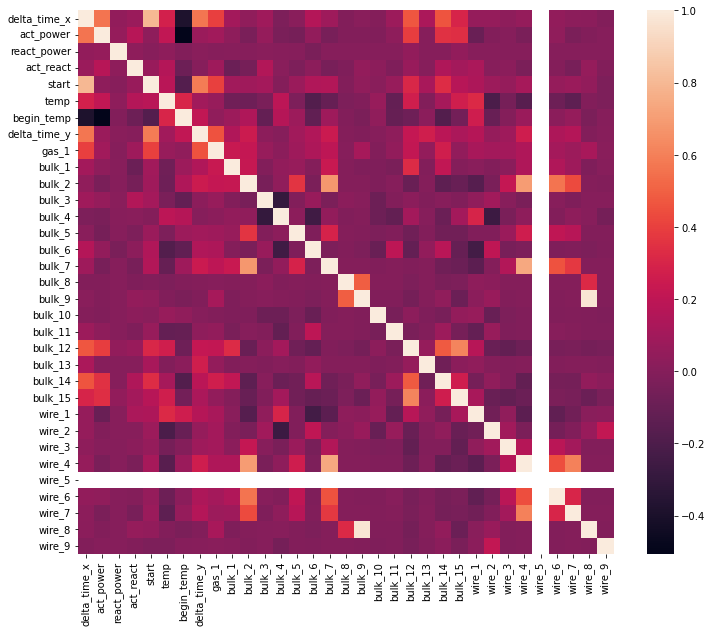

In [86]:
plt.subplots(figsize=(12, 10))
sns.heatmap(sum_data.corr())

### 4.2.1. Примечания:
1. Неожиданно высокая корреляция межу bulk_9 и wire_8.
2. Странная аномалия с wire_5 - данные есть, а корреляция выдает NaN...
3. Диапазоны значений для каждого столбца сильно различаются. Возможно, надо пронормировать данные. НЕТ! Попробовал - результат вообще не изменился.

In [87]:
features = sum_data.drop(['temp'], axis=1)
target = sum_data['temp']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.20, random_state=RANDOM_STATE)
print('Размер features_train:', features_train.shape)
print('Размер target_train:', target_train.shape)
print('Размер features_test:', features_test.shape)
print('Размер target_test:', target_test.shape)

Размер features_train: (1860, 32)
Размер target_train: (1860,)
Размер features_test: (465, 32)
Размер target_test: (465,)


In [88]:
# удаляем лишние датасеты
del data_arc_temp
del data_bulk_wire
del act_react_arc

## 4.4. Прогон нескольких моделей регрессии

In [89]:
models = [DummyRegressor(strategy="median"),
          LinearRegression(),
          Ridge(random_state=RANDOM_STATE, solver='auto', max_iter=15000, fit_intercept=True, normalize=True),
          Lasso(random_state=RANDOM_STATE, max_iter=1000),
          DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=8), 
          RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=200, max_depth=10),
          ElasticNet(random_state=RANDOM_STATE),
          XGBRegressor(random_state=RANDOM_STATE, booster='gbtree', max_depth=4),
          CatBoostRegressor(loss_function='RMSE', l2_leaf_reg=8, learning_rate=0.03, bootstrap_type='MVS', depth=16, grow_policy='Lossguide', iterations=500, silent=True, random_seed=RANDOM_STATE),
          LGBMRegressor(boosting_type='gbdt', n_jobs=4, class_weight=None, learning_rate=0.03, n_estimators=300, random_state=RANDOM_STATE)
         ]

#CatBoostRegressor(task_type='GPU', devices='0', loss_function='MAE', l2_leaf_reg=8, learning_rate=0.05, bootstrap_type='Poisson', depth=16, grow_policy='Lossguide', iterations=2000, silent=True, random_seed=RANDOM_STATE),
# не везде есть GPU, пока не использую

results = []

for md in models: 
    print(f'Идут вычисления по модели {md.__class__.__name__}:', md.get_params(deep=False))
#    t1 = datetime.datetime.now() # Засекли время начала обучения
    md.fit(features_train, target_train)
#    t2 = datetime.datetime.now() # Время окончания обучения и начала предсказания
    print('-- модель обучена')
#    pred = md.predict(features_test)
#    t3 = datetime.datetime.now() # Время окончания предсказания
#    print('-- получены предсказания')
#    t4 = t2 - t1 # Время обучения
#    t5 = t3 - t2 # Время предсказания
#    dt1 = str(np.round(t4.total_seconds(), 2))+'s' # Время обучения в секундах
#    dt2 = str(np.round(t5.total_seconds(), 2))+'s' # Время предсказания в секундах

    cv_mae = abs(np.round(cross_val_score(md, features_train, target_train, cv=5, scoring='neg_mean_absolute_error').mean(), 4))
    print(f'-- cредняя оценка качества модели {md.__class__.__name__} методом кросс-валидации по метрике MAE:', cv_mae)
    
#    md_mae = np.round(mean_absolute_error(target_test, pred), 2)
       
#    print('-- MAE:', md_mae)
    results.append({'Модель': md.__class__.__name__, 
                    'mae_cv': cv_mae,
                    'Гиперпараметры': md.get_params(deep=False),
                    'md': md,
                    'Модель_пригодна': cv_mae < CRIT_MAE}) 

#                    'Время_обучения': dt1,
#                    'Время_предсказания': dt2,  
#                    'mae_test': md_mae,    
    print('')

Идут вычисления по модели DummyRegressor: {'constant': None, 'quantile': None, 'strategy': 'median'}
-- модель обучена
-- cредняя оценка качества модели DummyRegressor методом кросс-валидации по метрике MAE: 7.978

Идут вычисления по модели LinearRegression: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False}
-- модель обучена
-- cредняя оценка качества модели LinearRegression методом кросс-валидации по метрике MAE: 9.3334

Идут вычисления по модели Ridge: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 15000, 'normalize': True, 'positive': False, 'random_state': 250722, 'solver': 'auto', 'tol': 0.001}
-- модель обучена
-- cредняя оценка качества модели Ridge методом кросс-валидации по метрике MAE: 7.103

Идут вычисления по модели Lasso: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': 'deprecated', 'positive': False, 'precompute': False, 'random_state': 250722, 'selection': 'cyclic'

In [90]:
results = pd.DataFrame(results)
display(results.drop('md', axis=1))

,Модель,mae_cv,Гиперпараметры,Модель_пригодна
0,DummyRegressor,7.9780,"{'constant': None, 'quantile': None, 'strategy...",True
1,LinearRegression,9.3334,"{'copy_X': True, 'fit_intercept': True, 'n_job...",False
2,Ridge,7.1030,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",True
3,Lasso,5.9905,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",True
4,DecisionTreeRegressor,7.5142,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",True
5,RandomForestRegressor,5.9791,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",True
6,ElasticNet,5.9714,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",True
7,XGBRegressor,5.8377,"{'objective': 'reg:squarederror', 'base_score'...",True
8,CatBoostRegressor,5.5198,"{'iterations': 500, 'learning_rate': 0.03, 'de...",True
9,LGBMRegressor,5.5565,"{'boosting_type': 'gbdt', 'class_weight': None...",True


## 4.5. Определение лучшей модели

In [91]:
print('Лучшая модель:')
#best = results.sort_values(by='mae_cv').head(2)
#best = best.sort_values(by='Время_обучения').head(1).reset_index(drop=True)

best = results.sort_values(by='mae_cv').head(1).reset_index(drop=True)

display(best.drop('md', axis=1))

Лучшая модель:


,Модель,mae_cv,Гиперпараметры,Модель_пригодна
0,CatBoostRegressor,5.5198,"{'iterations': 500, 'learning_rate': 0.03, 'de...",True


In [92]:
best_model = best.loc[0, 'md']
pred = best_model.predict(features_test)
md_mae = np.round(mean_absolute_error(target_test, pred), 4)
print('MAE лучшей модели (на тестовой выборке):', md_mae)

MAE лучшей модели (на тестовой выборке): 5.9264


## 4.6. Улучшение лучшей модели (при помощи подбора гиперпараметров)

In [94]:
#%%time

# Сначала пробуем GridSearchCV
#params = {'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
#          'n_estimators': range(50, 400, 50),
#         'learning_rate': [0.03, 0.05, 0.1, 0.3],
#         'max_depth': [-1, 4, 6, 10],
#         'n_jobs': [4],
#         'random_state': [RANDOM_STATE]}

#model = LGBMRegressor()
#grid = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=5)
#grid.fit(features_train, target_train)

#print("Лучшие параметры для модели LGBMRegressor определенные GridSearchCV:", grid.best_params_)

In [95]:
#model = LGBMRegressor(boosting_type='goss', n_jobs=4, learning_rate=0.03, n_estimators=350, max_depth=4, random_state=RANDOM_STATE)
#model.fit(features_train, target_train)
#pred = model.predict(features_test)
#md_mae = np.round(mean_absolute_error(target_test, pred), 4)
#print('MAE лучшей модели (на тестовой выборке) после подбора гиперпараметров:', md_mae)

In [96]:
#%%time

# RandomizedSearchCV
#model = CatBoostRegressor()

#params = {'loss_function': ['RMSE', 'MAE'],
#          'iterations': [200, 300, 400, 500, 600],
#          'learning_rate': [0.03, 0.7, 0.15],
#          'l2_leaf_reg': [3, 8],
#          'bootstrap_type': ['Bayesian', 'MVS'],
#          'depth': [6, 10, 16],
#          'grow_policy': ['Lossguide', 'SymmetricTree'],
#          'silent': [True],
#          'random_state': [RANDOM_STATE]}

#grid = RandomizedSearchCV(model, params, cv = 3, scoring = 'neg_mean_absolute_error', n_iter=300, n_jobs = -1)
#grid.fit(features_train, target_train)

#best_estimator = grid.best_estimator_
#print(best_estimator)
#print(grid.best_score_)
#print("Лучшие параметры для модели CatBoostRegressor определенные RandomizedSearchCV:", grid.best_params_)

CPU times: total: 0 ns
Wall time: 0 ns


In [97]:
#%%time

# RandomizedSearchCV
#model = CatBoostRegressor()

#params = {'task_type': ['GPU'],
#          'devices': ['0'],
#          'loss_function': ['MAE'],
#          'iterations': [200, 500, 1000],
#          'learning_rate': [0.03, 0.7, 0.15],
#          'l2_leaf_reg': [3, 8],
#          'bootstrap_type': ['Poisson'],
#          'depth': [6, 8],
#          'grow_policy': ['Lossguide', 'SymmetricTree'],
#          'silent': [True],
#          'random_state': [RANDOM_STATE]}

#grid = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=3)
#grid.fit(features_train, target_train)

#print(grid.best_score_)
#print("Лучшие параметры для модели CatBoostRegressor определенные RandomizedSearchCV:", grid.best_params_)

In [109]:
# задаем тот же набор параметров что и для метода выше
params = {'loss_function': ['RMSE', 'MAE'],
          'iterations': [200, 400, 500, 700],
          'learning_rate': [0.03, 0.15],
          'l2_leaf_reg': [3, 8],
          'bootstrap_type': ['Bayesian', 'MVS'],
          'depth': [6, 10, 16],
          'grow_policy': ['Lossguide'],
          'silent': True,
          'random_state': RANDOM_STATE}

best_cv = 100
res_cv = []

for loss_function in params['loss_function']:
    for bootstrap_type in params['bootstrap_type']:
        for grow_policy in params['grow_policy']:
            for iterations in params['iterations']:
                for learning_rate in params['learning_rate']:
                    for l2_leaf_reg in params['l2_leaf_reg']:
                        for depth in params['depth']:
                            md = CatBoostRegressor(loss_function=loss_function,
                                                   l2_leaf_reg=l2_leaf_reg,
                                                   learning_rate=learning_rate,
                                                   bootstrap_type=bootstrap_type,
                                                   depth=depth, 
                                                   grow_policy=grow_policy,
                                                   iterations=iterations,
                                                   silent=params['silent'],
                                                   random_seed=params['random_state'])

                            print(f'Идут вычисления по модели {md.__class__.__name__}:', md.get_params(deep=False))
                            md.fit(features_train, target_train)
                            print('-- модель обучена')
                            mae_cv = abs(np.round(cross_val_score(md, features_train, target_train, cv=3, scoring='neg_mean_absolute_error').mean(), 6))
                            print(f'-- cредняя оценка качества модели {md.__class__.__name__} методом кросс-валидации по метрике MAE:', cv_mae)                        

                            if cv_mae < best_cv:
                                best_cv = mae_cv
                                best_md = md
                            
                            res_cv.append({'mae_cv': mae_cv, 
                                           'loss_function': loss_function,
                                           'l2_leaf_reg': l2_leaf_reg,
                                           'learning_rate': learning_rate,
                                           'bootstrap_type': bootstrap_type,
                                           'depth': depth,
                                           'grow_policy': grow_policy,
                                           'iterations': iterations,                                           
                                          }) 
                            
                            print('')    

Идут вычисления по модели CatBoostRegressor: {'iterations': 200, 'learning_rate': 0.03, 'depth': 6, 'l2_leaf_reg': 3, 'loss_function': 'RMSE', 'random_seed': 250722, 'silent': True, 'bootstrap_type': 'Bayesian', 'grow_policy': 'Lossguide'}


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

-- модель обучена
-- cредняя оценка качества модели CatBoostRegressor методом кросс-валидации по метрике MAE: 6.0787

Идут вычисления по модели CatBoostRegressor: {'iterations': 200, 'learning_rate': 0.03, 'depth': 10, 'l2_leaf_reg': 3, 'loss_function': 'RMSE', 'random_seed': 250722, 'silent': True, 'bootstrap_type': 'Bayesian', 'grow_policy': 'Lossguide'}
-- модель обучена
-- cредняя оценка качества модели CatBoostRegressor методом кросс-валидации по метрике MAE: 6.0787

Идут вычисления по модели CatBoostRegressor: {'iterations': 200, 'learning_rate': 0.03, 'depth': 16, 'l2_leaf_reg': 3, 'loss_function': 'RMSE', 'random_seed': 250722, 'silent': True, 'bootstrap_type': 'Bayesian', 'grow_policy': 'Lossguide'}
-- модель обучена
-- cредняя оценка качества модели CatBoostRegressor методом кросс-валидации по метрике MAE: 6.0787

Идут вычисления по модели CatBoostRegressor: {'iterations': 200, 'learning_rate': 0.03, 'depth': 6, 'l2_leaf_reg': 8, 'loss_function': 'RMSE', 'random_seed': 250722

In [110]:
res_cv = pd.DataFrame(res_cv)
print('Лучшие гиперпараметры для модели:')
display(res_cv.sort_values(by='mae_cv').head(1))

Лучшие гиперпараметры для модели:


,mae_cv,loss_function,l2_leaf_reg,learning_rate,bootstrap_type,depth,grow_policy,iterations
39,5.522997,RMSE,8,0.03,Bayesian,6,Lossguide,700


In [111]:
best_md.predict(features_test)
best_md_mae = np.round(mean_absolute_error(target_test, pred), 6)
print('MAE лучшей модели при лучших гиперпараметрах (на тестовой выборке):', best_md_mae)

MAE лучшей модели при лучших гиперпараметрах (на тестовой выборке): 5.926383


### Примечания:
* Мне показалось, что GridSearchCV дал неоптимальные параметры, т.к. результаты получились хуже чем с начальными значениями проставленными интуитивно. Поэтому я попробовал RandomizedSearchCV. Но при подборе параметров CatBoostRegressor ядро виснет и на том и на другом (причем прогресс-бар или какие-то промежуточные выводы отсутствуют и зависание можно оценить только по тому что перестает действовать Kernel/Interrupt). А с использованием GPU - умирает с выводом соответствующей ошибки. Поэтому ниже делаю перебор значений.
* Как показал перебор, модель вешается на grow_policy='SymmetricTree' и depth=16. Depthwise работает очень медленно и дает более плохие результаты чем Lossguide, поэтому оставил только Lossguide.
* Перебор параметров производился с оценкой MAE по кросс-валидации тренировочной выборки, а затем итоговая модель оценивалась на тестовой.

# 5. Отчет

## 5.1. Предобработка
1. data_arc:
* key - каждому ключу партии может соответствовать несколько записей по ней, соответственно, необходимо было сформировать новые признаки на основе совокупности данных по каждой партии.
* Начало нагрева дугой  - приведено к формату времени, переименовано в begin_time.
* Конец нагрева дугой   - приведено к формату времени, переименовано в end_time. 
* По разнице begin_temp и end_temp получено время нагрева и сохранено в delta_time (в секундах, в формате int). Сами begin_temp и end_temp в итоговый датасет не вошли. При формировании итогового датасета эти данные вошли в delta_time_x.
* Активная мощность     - переименовано в act_power, взято среднее значение по партии и сохранено в act_power.
* Реактивная мощность   - переименовано в react_power, взято среднее значение по партии и сохранено в react_power. 
* Среднее отношение активной к реактивной мощности сохранено в act_react.
2. data_bulk:
* key - каждому ключу партии соответствует только одна запись по ней, соответственно, необходимость в формировании новых признаков отсутствует.
* Bulk N - содержит количества добавленных сыпучих материалов из разных бункеров (N=1..15), переименованы в bulk_N. Вошли в итоговый датасет без изменений. 
3. data_bulk_time: соответствует data_bulk, содержит время добавления сыпучих материалов. Интереса для данных исследований не представляет, был отброшен в процессе компоновки итогового датасета.
4. data_gas: 
* key - каждому ключу партии соответствует только одна запись по ней, соответственно, необходимость в формировании новых признаков отсутствует.
* Газ 1 - переименновано в gas_1. Вошло в итоговый датасет без изменений. 
5. data_temp:
* key - каждому ключу партии может соответствовать несколько записей по ней, соответственно, необходимо было сформировать новые признаки на основе совокупности данных по каждой партии. Были ключи, по которым были пропущенные значения, пропуски были удалены. Были ключи, где было единственное значение температуры, такие ключи были добавлены в список на удаление по всем датасетам.
* Время замера - приведено к формату времени, переименовано в temp. По нему брались значение начальной и конечной температуры, а также был сформирован новый признак с временем между первым и последним замером температуры (в секундах в формате int). При формировании итогового датасета эти данные вошли в delta_time_y.
* Температура  - переименована в temp, ключи со значениями ниже 1500 вошли в список на удаление по всем датасетам, были взяты значения начальной begin_temp и конечной end_temp температур.
6. data_wire:
* key - каждому ключу партии соответствует только одна запись по ней, соответственно, необходимость в формировании новых признаков отсутствует.
* Wire N - содержит количества добавленных проволочных материалов из разных катушек (N=1..9), переименованы в wire_N. Вошли в итоговый датасет без изменений. 
7. data_wire_time: соответствует data_wire, содержит время добавления проволочных материалов. Интереса для данных исследований не представляет, был отброшен в процессе компоновки итогового датасета.
8. Были выявлены ключи партий, по которым нет полного набора данных. По этим ключам были отброшены записи во всех датасетах перед включением их в итоговый датасет.

## 5.2. Описание итогового датасета:
Итоговый датасет sum_data включил в себя 2325 записи по следующим столбцам:
* key (int64) - ключ партии (был удалён перед обучением модели т.к. не несет в себе полезной информации для обучения);
* delta_time_x (int32) - суммарное время нагрева по партии (в сек.);
* act_power (float64) - средняя активная мощность по партии;
* react_power (float64) - средняя реактивная мощность по партии;
* act_react (float64) - среднее отношение активной мощности к реактивной по партии;
* start (int64) - количество запусков дуги;
* temp (float64) - конечная температура (целевой признак);
* begin_temp (float64) - начальная температура;
* delta_time_y (int32) - время между первым и последним замером температуры по партиям (сек.);
* gas_1 (float64) - количество газа;
* bulk_1..bulk_15 (float64) - количество сыпучих материалов по бункерам;
* wire_1..wire_9 (float64) - количество сыпучих материалов по катушкам.

# 5.3. Обучающая и тестовая выборки
Обучающая и тестовая выборки были сформированы в соотношении 80% / 20% от итогового датасета (без столбца key). В качестве целевого признака используется стобец <b>temp</b>.
* Размер features_train: (1860, 32)
* Размер target_train: (1860,)
* Размер features_test: (465, 32)
* Размер target_test: (465,)

## 5.4. Выбор лучшей модели
1. Было взято несколько моделей с гиперпараметрами по умолчанию (или взятыми интуитивно): LinearRegression, Ridge, Lasso, DecisionTreeRegressor, RandomForestRegressor, ElasticNet, XGBRegressor, CatBoostRegressor, LGBMRegressor. Для оценки их адекватности также была взята DummyRegressor. По ним была проведена оценка МАЕ на кросс-валидации с cv=5 и взято среднее значение МАЕ.
2. Модель LinearRegression показала результаты хуже DummyRegressor (по всей видимости, из-за того, что входные данные не были нормированы, для всех остальных моделей нормировка ничего не дает).
3. В целом все модели показали удовлетворительный результат (MAE на кросс-валидации < 8.7). И даже  DummyRegressor :) Что говорит о том, что модель с MAE выше 7.9 в принципе нельзя использовать.
4. Хорошие результаты (MAE на кросс-валидации < 6.0) показали: Lasso, RandomForestRegressor, ElasticNet, GBRegressor, CatBoostRegressor, LGBMRegressor.
5. Лучший результат на кросс-валидации (MAE=5.5198) показала модель <b>CatBoostRegressor</b> со следующими гиперапараметрами:
* loss_function='RMSE'
* l2_leaf_reg=8
* learning_rate=0.03
* bootstrap_type='MVS'
* depth=16
* grow_policy='Lossguide'
* iterations=500

## 5.5. Подбор гиперпараметров
1. Для подбора гиперпараметров использовалось следующее их множество:
* loss_function: ['RMSE', 'MAE']
* iterations: [200, 400, 500, 700]
* learning_rate: [0.03, 0.15]
* l2_leaf_reg: [3, 8]
* bootstrap_type: ['Bayesian', 'MVS']
* depth: [6, 10, 16]
* grow_policy: ['Lossguide']
* silent: True
* random_state: 250722
2. Методы GridSearchCV и RandomizedSearchCV в данном случае показали плохие результаты, т.к. не выдают логирование промежуточных результатов, имеют долгое время работы и их работу невозможно контролировать.
3. Поэтому подбор гиперпараметров производился методом их последовательного перебора с вычислением средней МАЕ на кросс-валидации с cv=3 и логированием промежуточных результатов (и сохранением их в датасет res_cv для возможности последующего анализа с целью более тонкой подборки). 
4. Наилучший результат (МАЕ на кросс-валидации 5.522997) был достигнут на следующем наборе параметров:
* loss_function: RMSE
* iterations: 700
* learning_rate: 0.03
* l2_leaf_reg: 8
* bootstrap_type: Bayesian
* depth: 6
* grow_policy: Lossguide
5. На тестовой выборке данная модель (с подобранными гиперпараметрами) показала МАЕ=5.926383

## 5.6. В отчёте ответьте на вопросы:
1. Какие пункты плана были выполнены, а какие — нет (поясните почему)?
2. Какие трудности возникли и как вы их преодолели?
3. Какие ключевые шаги в решении задачи выделили?
4. Какая ваша итоговая модель и какое у неё качество?

### 5.6.1. Какие пункты плана были выполнены, а какие — нет
В целом, все пункты плана были выполнены, но в процессе произошли следующие изменения:
* были сформированы дополнительные признаки (количество запусков дуг, среднее отношение активной мощности к реактивной, начальные температуры, суммарное время нагрева);
* были отброшены данные где начальная температура < 1500 или для партии единственный замер температуры;
* изменилось соотношение обучающей выборки к тестовой в пользу тестовой, т.к. после отбрасывания данных с единственным замером температуры датасет существенно уменьшился (примерно на четверть).

### 5.6.2. Какие трудности возникли и как вы их преодолели
* Некую сложность представлял собой исследовательский анализ данных, т.к. задачи для него по-хороему должен формулировать технолог, знающий техпроцесс. В итоге я сразу стал делать дополнительное задание (п.3) в основном использовал его результаты.
* Вначале МАЕ для всех моделей был в диапазоне 10..11, но после удаления некорректных записей он существенно улучшился. А после формирования дополнительных признаков (честно скажу - я их перечень брал из доп-задания, которое было мною выполнено в п.3).
* Подбор параметров методами GridSearchCV и RandomizedSearchCV отнял целый день и не принес результатов. В итоге я написал свой код для подбора гиперпараметров, которым, на мой взгляд, пользоваться удобнее, т.к. он выводит промежуточные результаты по процессу подбора.

### 5.6.3. Какие ключевые шаги в решении задачи выделили?
1. Первичное знакомство с данными
2. Предобработка данных
3. Иссладовательский анализ данных
4. Выполнение доплнительного задания (п.3)
5. Подготовка итогового татафрейма
6. Подготовка обучающей и тестовой выборок
7. Выбор лучшей модели
8. Подбор гиперпараметров
9. Финальное тестирование на тестовой выборке

### 5.6.4. Какая ваша итоговая модель и какое у неё качество?
Итоговая модель - <b>CatBoostRegressor</b> со следующими гиперапараметрами:
* loss_function: RMSE
* iterations: 700
* learning_rate: 0.03
* l2_leaf_reg: 8
* bootstrap_type: Bayesian
* depth: 6
* grow_policy: Lossguide
<br><br>
На тестовой выборке данная модель (с подобранными гиперпараметрами) показала МАЕ=<b>5.926383</b>, на кросс-валидации 5.522997.